# Using the circles calibration image

In [2]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import skimage
from skimage.feature import blob_dog, blob_doh, blob_log, canny
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.segmentation import slic
from skimage.filters import sobel
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage import measure
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

# Determining the circles centers coordinates

In [3]:
circles = pyfits.getdata('calibration_circles.fits')


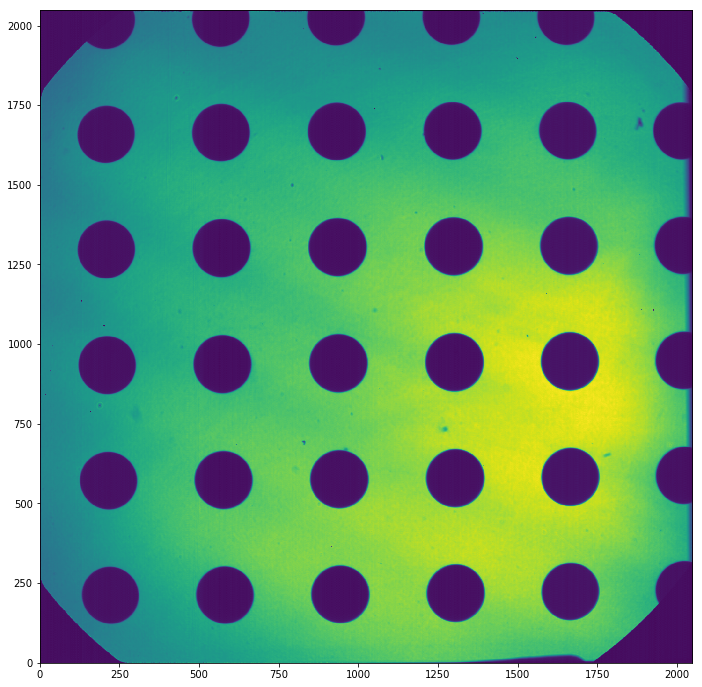

In [4]:
plt.figure(figsize=(18,12))

plt.imshow(circles, origin='lower')
plt.savefig('circles',dpi=300)

In [5]:
circles = circles/circles.mean()

In [6]:
hdu = pyfits.PrimaryHDU(circles)
#hdu.writeto('circles_norm.fits')

In [7]:
mask = np.zeros((2048,2048))
for i in range(2048):
    for j in range(2048):
        if circles[i][j] < 0.6:
            mask[i][j] = 1
        else:
            mask[i][j] = 0


In [8]:
hdu = pyfits.PrimaryHDU(mask)
#hdu.writeto('circles_mask.fits')

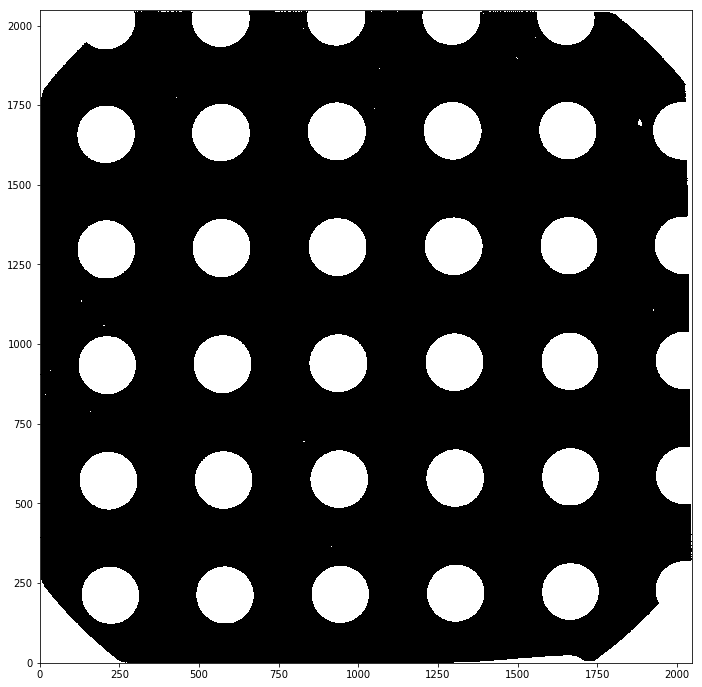

In [9]:
plt.figure(figsize=(18,12))

plt.imshow(mask,cmap='gray', origin='lower')

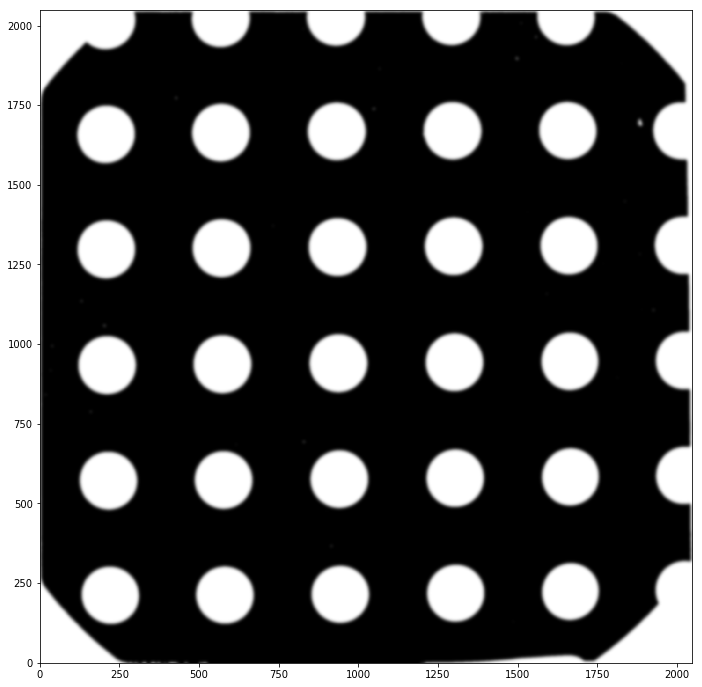

In [10]:

from scipy.ndimage.filters import gaussian_filter as gf
mask_smooth = gf(mask,sigma=5,mode='nearest')
mask_smooth.max()
fig = plt.figure(figsize=(18,12))
plt.imshow(mask_smooth,cmap='gray',origin='lower')
hdu = pyfits.PrimaryHDU(mask_smooth)
#hdu.writeto('mask_smooth_circles.fits')

In [11]:
mask_2 = np.zeros((2048,2048))
for i in range(2048):
         for j in range(2048):
             if mask_smooth[i][j] > 0.6:

                   mask_2[i][j] = 1
             else:
                   mask_2[i][j] = 0

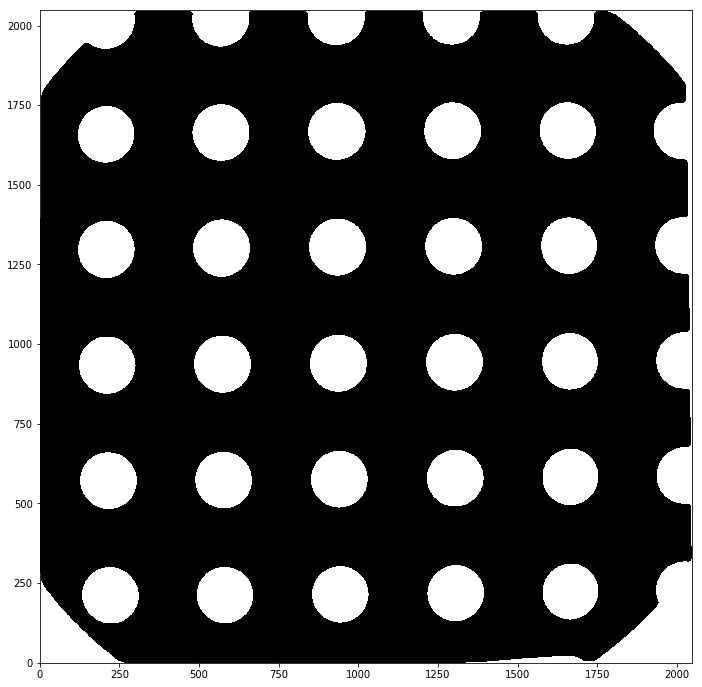

In [12]:
fig = plt.figure(figsize=(18,12))
plt.imshow(mask_2,cmap='gray',origin='lower')
hdu = pyfits.PrimaryHDU(mask_2)
plt.savefig('binary_circles.png',dpi=300)
#hdu.writeto('extended_circles.fits')

# Labeling features using the sequential region labeling in skimage

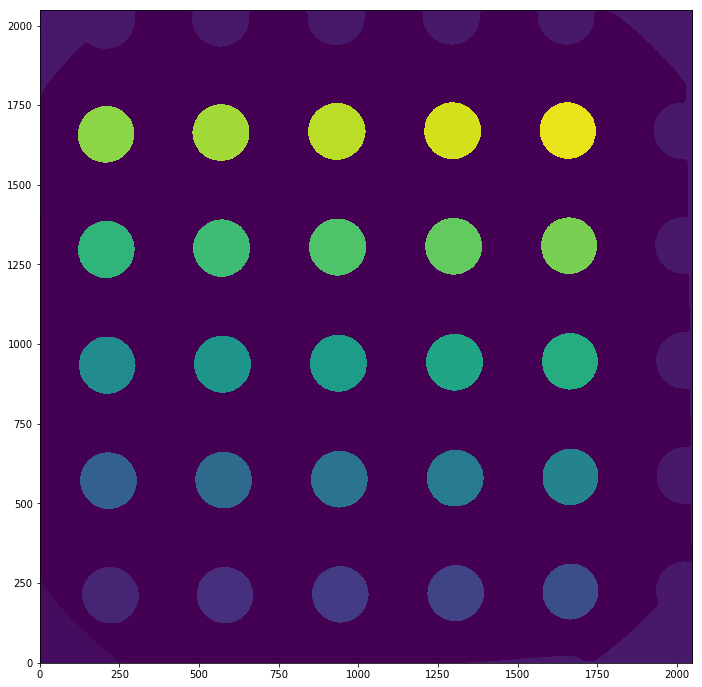

In [16]:
from skimage import measure
from skimage.measure import label
from skimage.measure import regionprops

labels, numb = measure.label(mask_2,background=0, return_num=True)
fig = plt.figure(figsize=(18,12))

plt.imshow(labels, origin='lower')
plt.savefig('labels_circles.png',dpi=300)

In [17]:
props = skimage.measure.regionprops(labels)
centers = np.array([prop.centroid for prop in props])
eccen = np.array([prop.eccentricity for prop in props])
R_eq =  np.array([prop.equivalent_diameter for prop in props])
moments_central = np.array([prop.moments for prop in props])
diameter = np.array([prop.equivalent_diameter for prop in props])
area = np.array([prop.area for prop in props])
major =  np.array([prop.major_axis_length for prop in props])
minor = np.array([prop.minor_axis_length for prop in props])
print major/minor
#print eccen
#print moments_central[0].shape
#print diameter
#print 2*np.sqrt(area/np.pi)

[ 1.81742676  1.83985983  1.02236881  1.01181635  1.00727974  1.01200482
  1.02189062         inf  1.01274483  1.00441373  1.00111527  1.00625171
  1.01528526  1.0114089   1.00418396  1.00320184  1.0050895   1.01204674
  1.01186028  1.00440516  1.00105013  1.00096328  1.00898163  1.01900053
  1.00767101  1.00753621  1.0071054   1.01505011  1.63299316]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


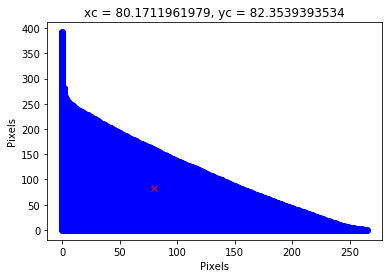

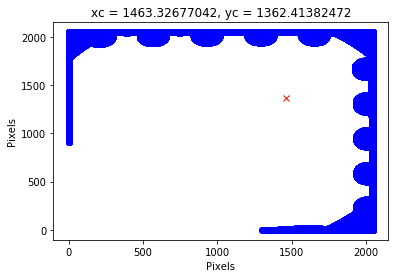

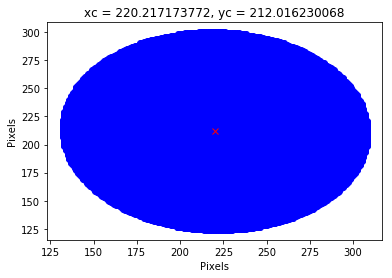

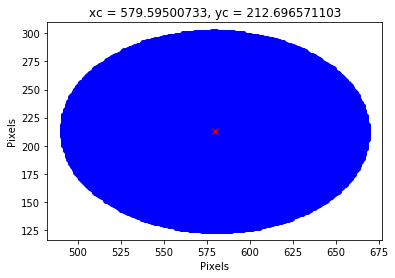

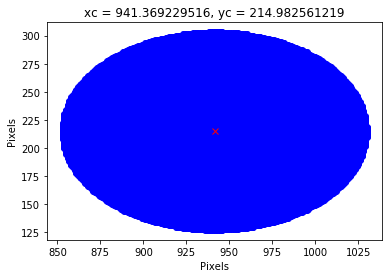

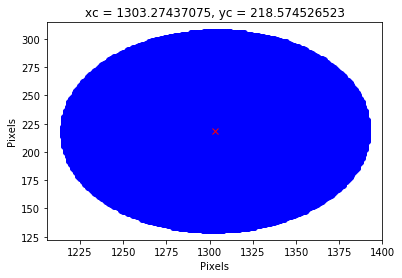

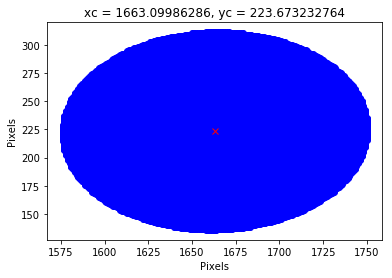

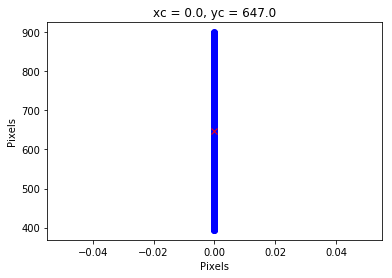

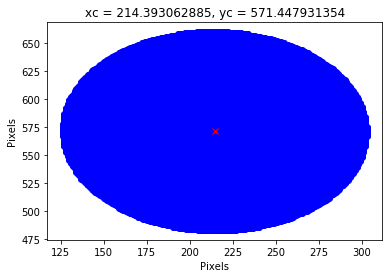

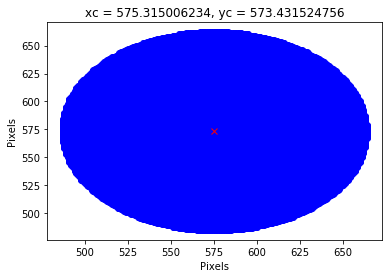

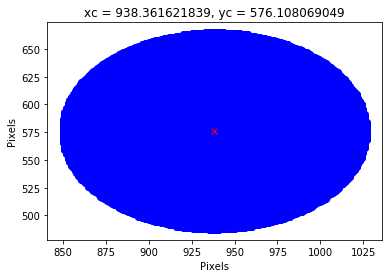

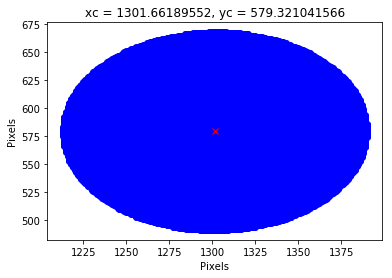

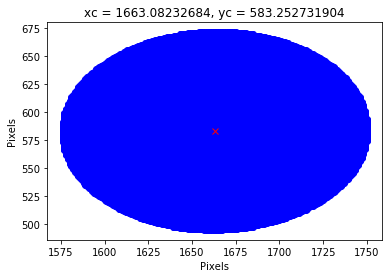

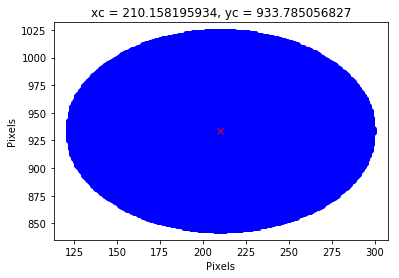

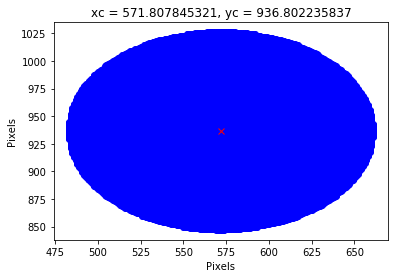

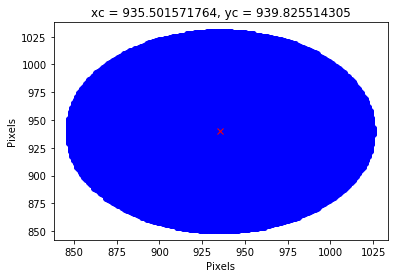

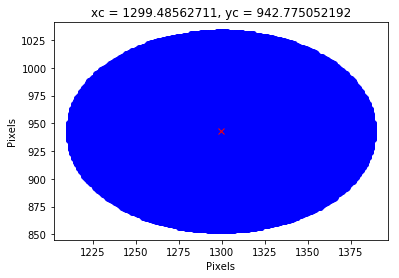

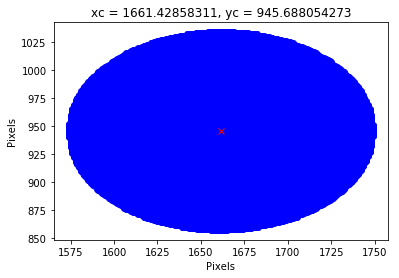

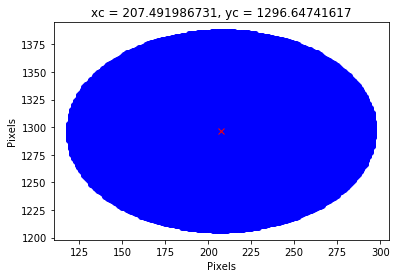

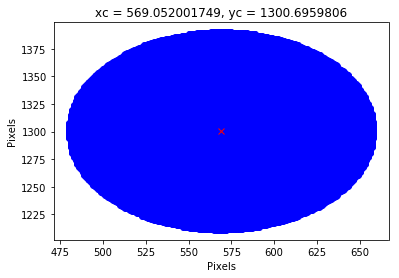

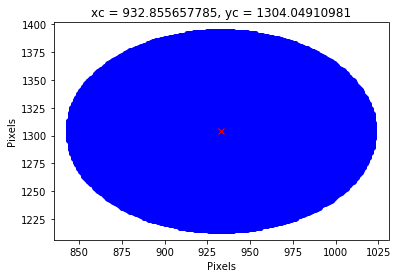

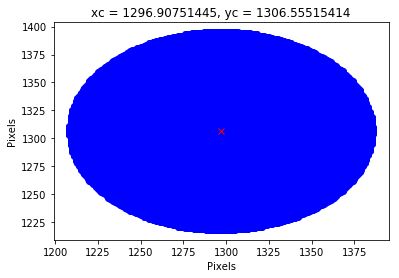

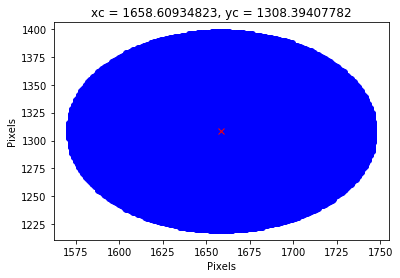

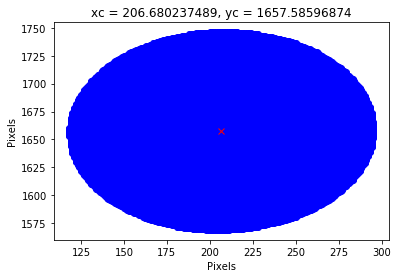

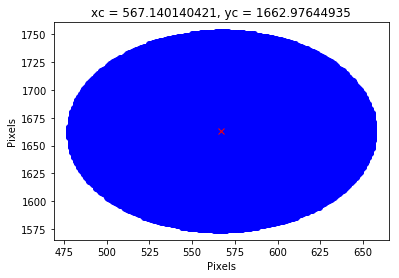

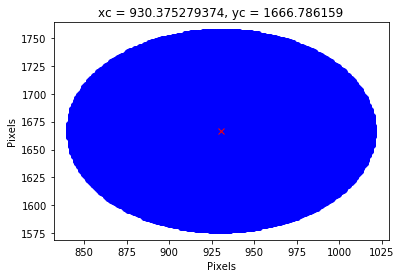

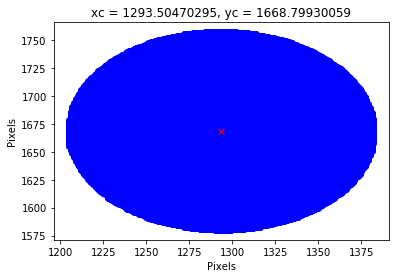

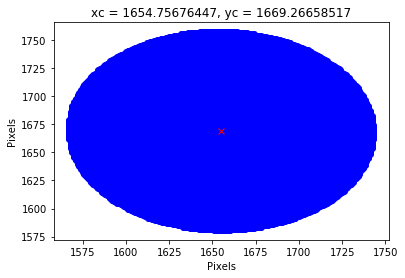

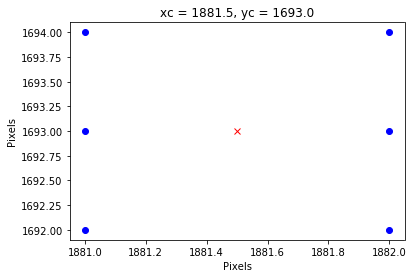

In [14]:
for i in np.arange(numb):
    y, x = props[i].coords[:,0], props[i].coords[:,1]
    yc, xc = props[i].centroid
    plt.plot(x,y,'bo')
    plt.plot(xc,yc,'rx')
    #plt.title('Feature# '+str(label),fontsize=22)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    plt.title('xc = '+str(xc)+', yc = '+str(yc))
    plt.show()
#plt.show()

# Fitting detected circles and deriving their centers

160.970855859
1248.76240376
58.9793577186
58.9419337387
58.9254055974
58.7472028845
58.3508515444
4465195.55955
59.2617485209
59.3078475795
59.3637095781
59.1516994597
58.6854511768
59.4579922655
59.632636065
59.6265862237
59.3616159087
58.8374843285
59.497386951
59.6528093941
59.5979579424
59.366107781
58.8956451871
59.187470992
59.3823342519
59.538061362
59.3261588365
58.923693496
0.912022659167


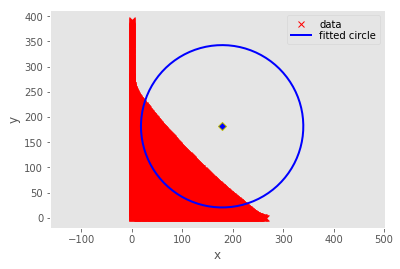

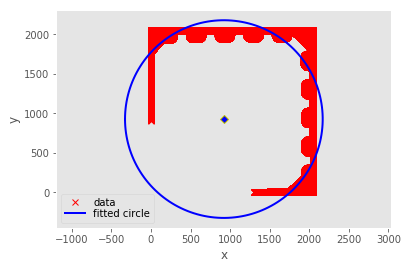

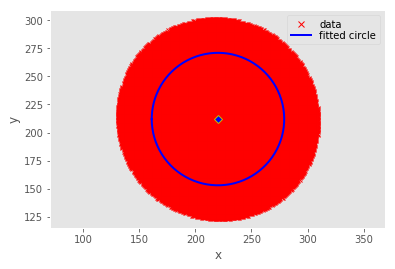

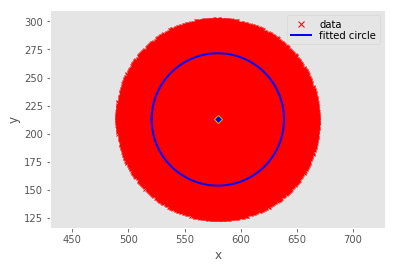

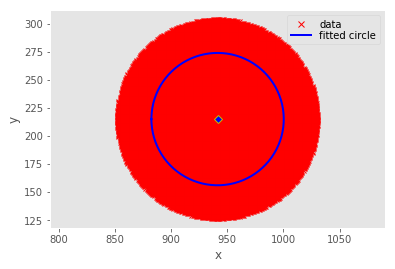

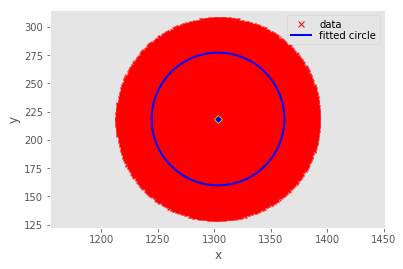

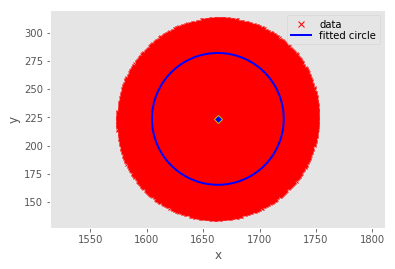

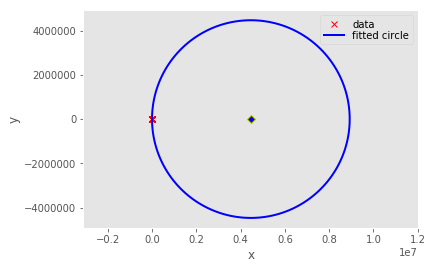

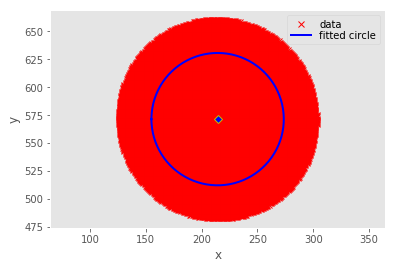

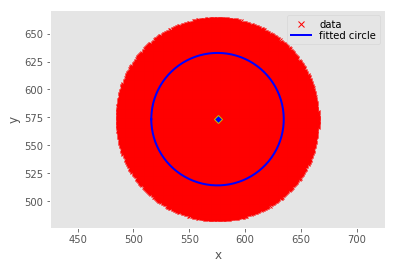

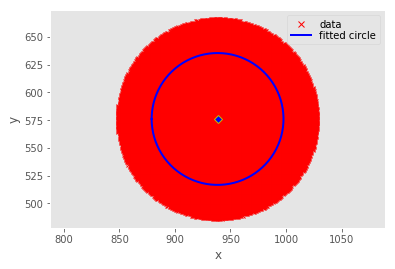

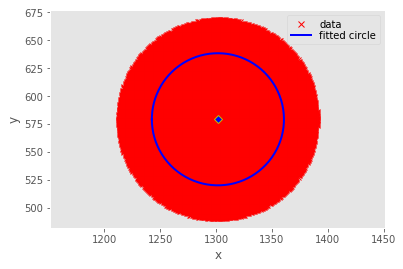

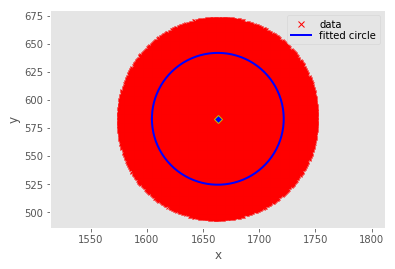

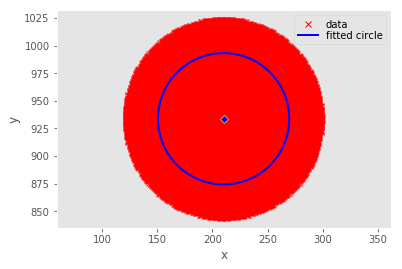

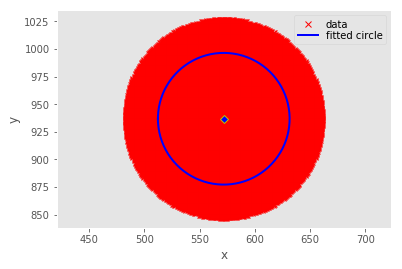

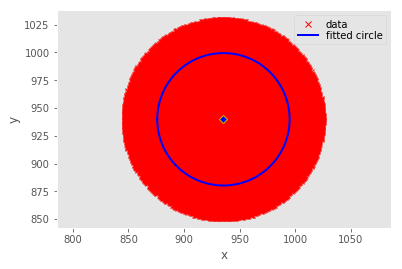

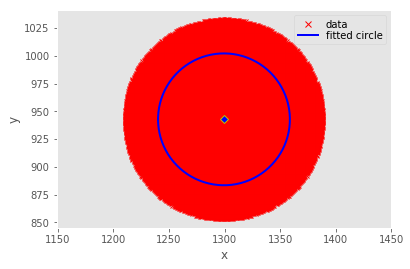

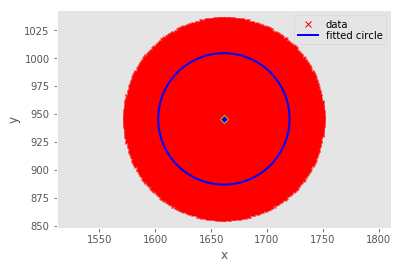

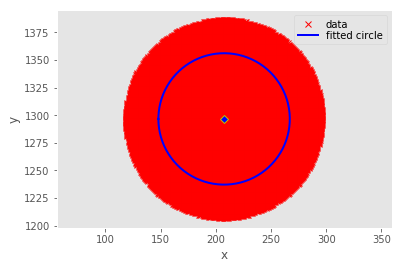

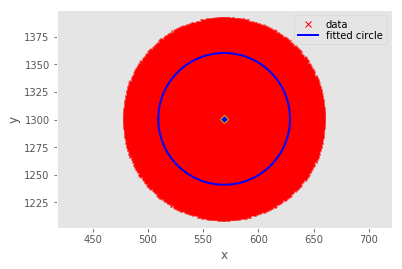

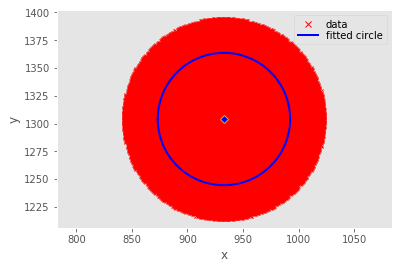

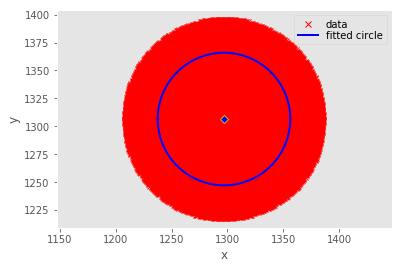

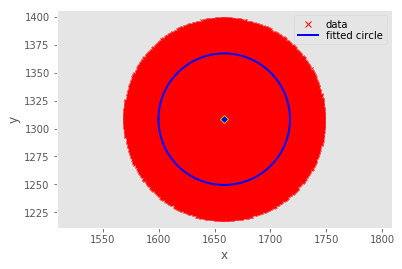

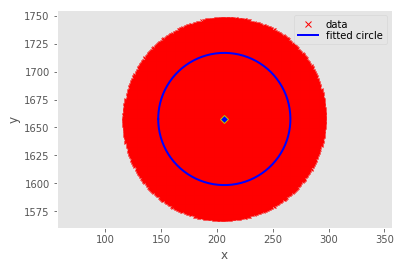

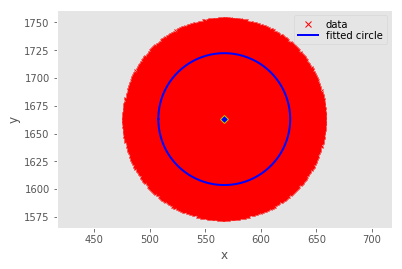

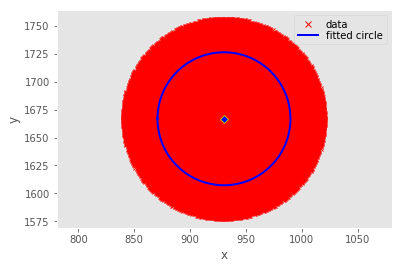

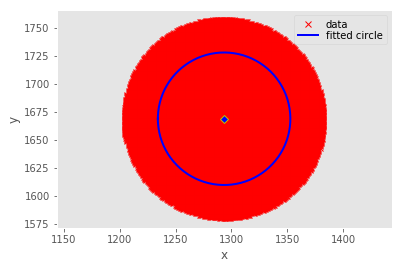

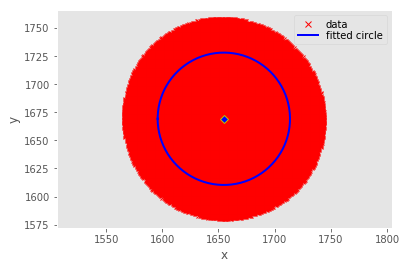

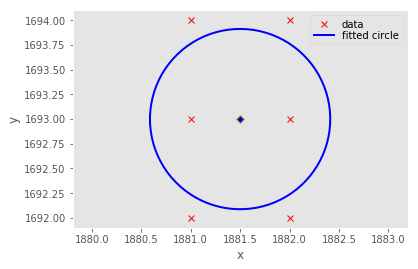

In [67]:
from scipy  import optimize


def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()



def leastsq_circle(x_m,y_m,x,y):
    # coordinates of the barycenter
    #x_m = np.mean(x)
    #y_m = np.mean(y)
    center_estimate = x_m, y_m
    #print x_m,y_m
    center, pcov  = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    s_sq= np.sum(f(center, x,y)**2)/(len(x)-len(center))
    pcov = pcov * s_sq    
    #err = np.sqrt(np.diag(pcov))
    Ri       = calc_R(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return xc, yc, R

def plot_data_circle(x,y, xc, yc, R):
    f = plt.figure( facecolor='white')  #figsize=(7, 5.4), dpi=72,
    plt.axis('equal')

    theta_fit = np.linspace(-np.pi, np.pi, 180)

    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.xlabel('x')
    plt.ylabel('y')   
    # plot data
    plt.plot(x, y, 'rx', label='data', mew=1)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)
    plt.legend(loc='best',labelspacing=0.1 )

    plt.grid()
    #plt.title('Least Squares Circle')





## loop on features:
for i in np.arange(numb):
    y,x = props[i].coords[:,0], props[i].coords[:,1]
    y_m, x_m = props[i].centroid
    #yc,xc = props[i].centroid
    #R_eq = props[i].major_axis_length
    #plt.plot(x,y,'rx')
    #plt.Circle((xc,yc),R_eq/2,color='blue')
    #plt.show()
    xc, yc, R = leastsq_circle(x_m,y_m,x,y)
    print R
   # print R
  #print xc, yc
    plot_data_circle(x,y,xc,yc,R)  

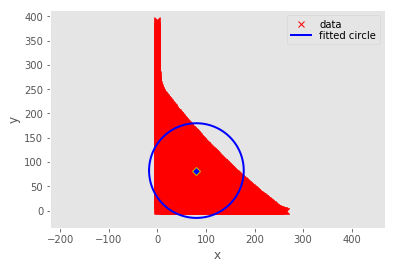

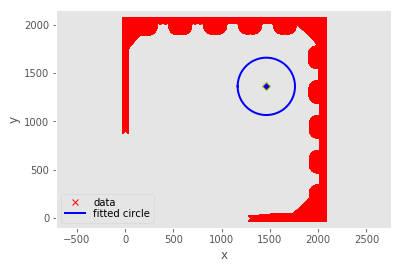

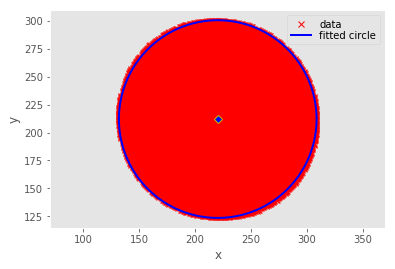

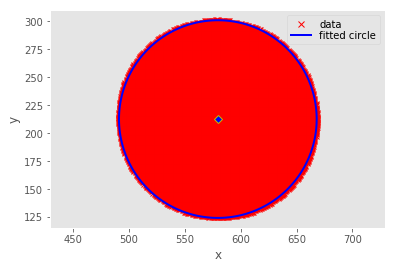

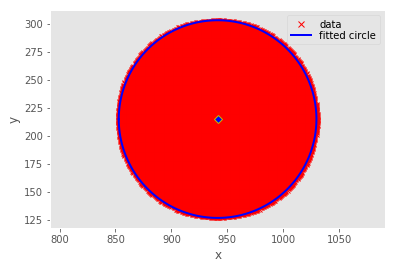

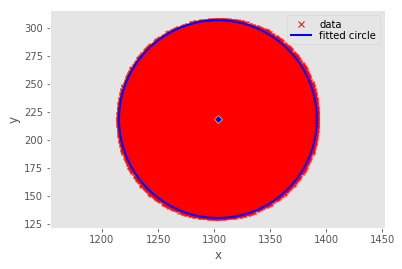

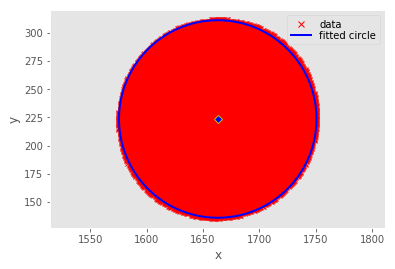

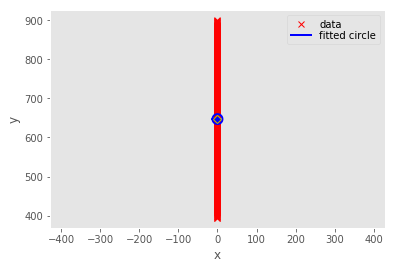

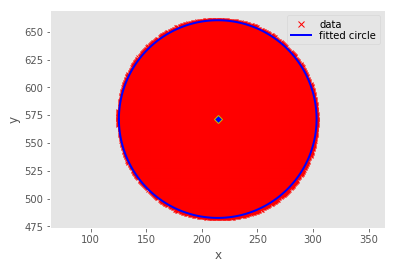

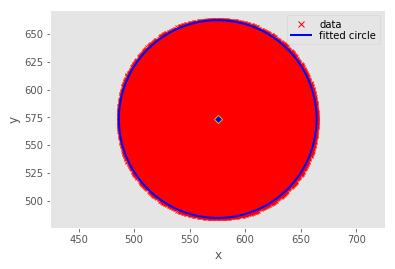

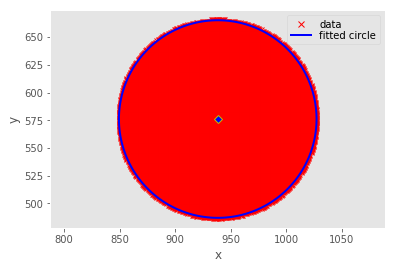

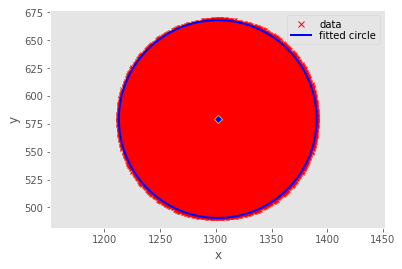

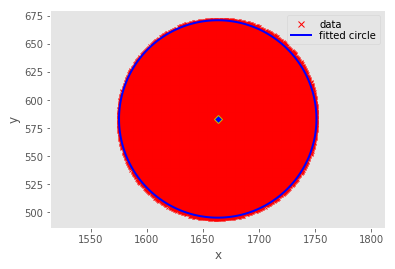

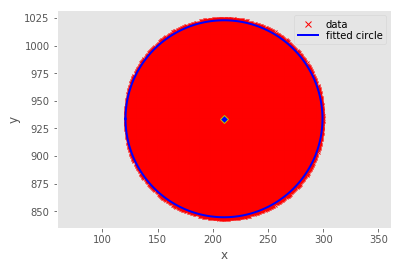

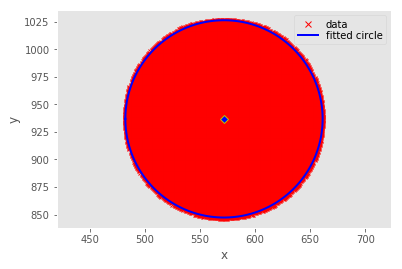

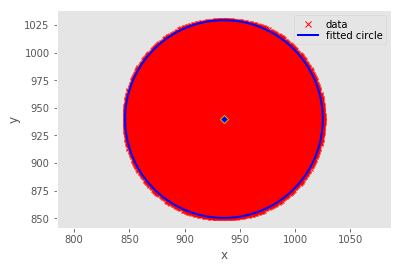

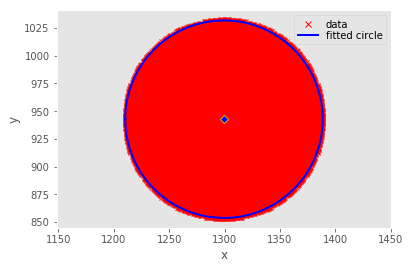

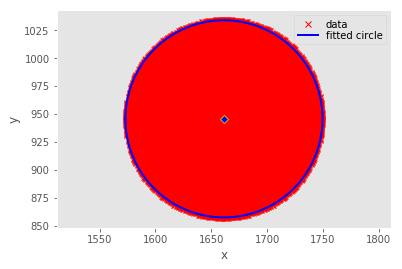

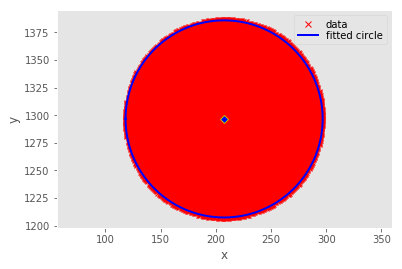

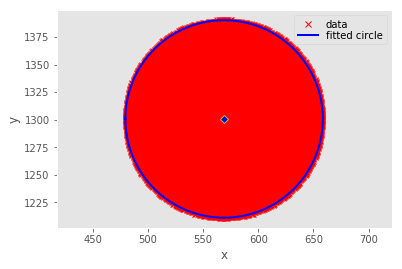

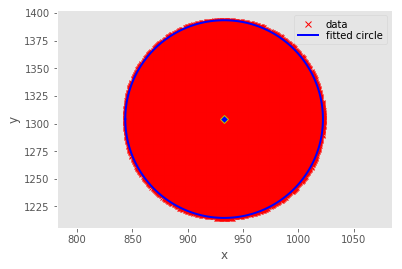

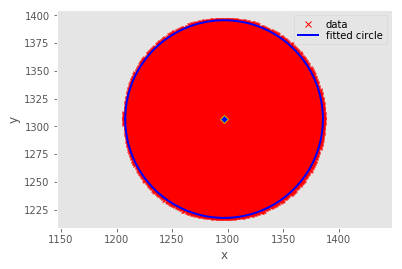

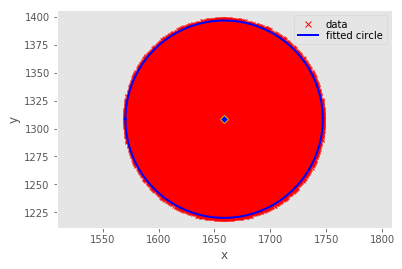

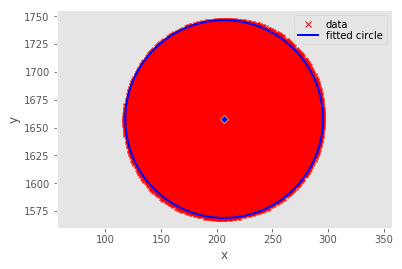

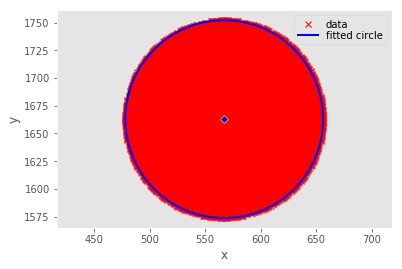

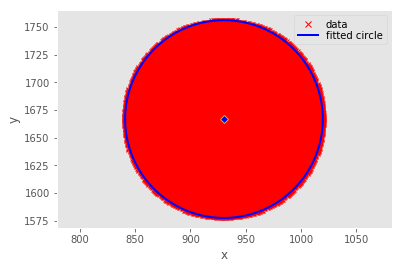

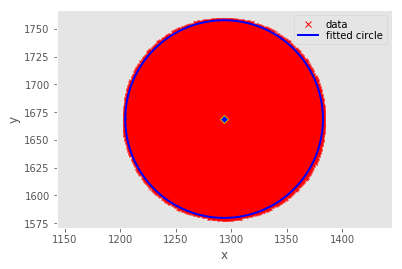

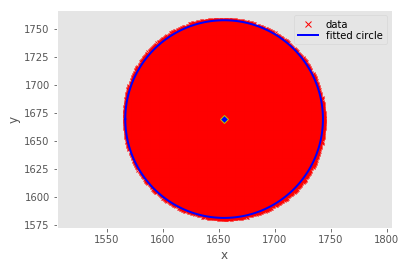

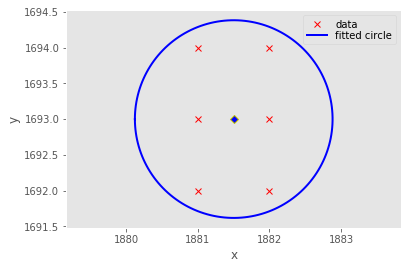

In [71]:
for i in np.arange(numb):
    y,x = props[i].coords[:,0], props[i].coords[:,1]
    R = props[i].equivalent_diameter/2.
    yc, xc = props[i].centroid
    plot_data_circle(x,y,xc,yc,R)  

In [17]:
center_estimate = x_m, y_m
pfit, pcov = optimize.leastsq(f, center_estimate, args=(x,y))
xc, yc = center
s_sq= np.sum(f(center, x,y)**2)/(len(x)-len(center))
s_sq
#pcov = pcov * s_sq  
#pcov

#err = np.sqrt(np.diag(pcov))

NameError: name 'center' is not defined

In [72]:
'''
F = open('Centers_python_circles','w')
for i in range(numb):
    F.write(str(centers[i][1]) + ' '+ str(centers[i][0])+'\n')
F.close()
'''

"\nF = open('Centers_python_circles','w')\nfor i in range(numb):\n    F.write(str(centers[i][1]) + ' '+ str(centers[i][0])+'\n')\nF.close()\n"

# Distortion work

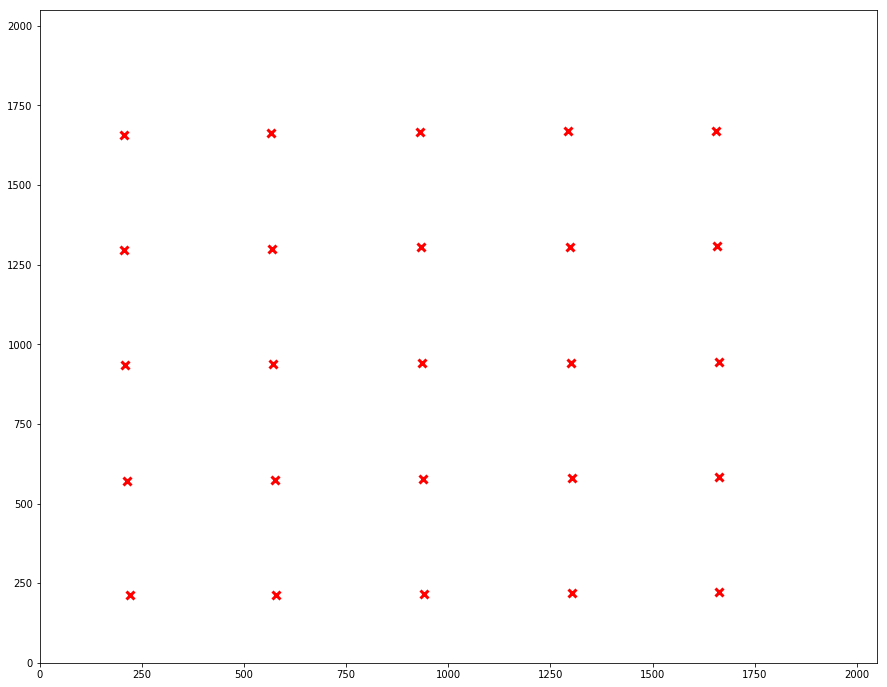

In [4]:
import os
#p = os.getcwd()
fig = plt.figure(figsize=(15,12))
lines = np.loadtxt('/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/centers_python_lines_circles')
columns = np.loadtxt('/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/centers_python_columns_circles')
plt.plot(lines[:,0], lines[:,1],'rx',markersize=8,mew=3)
plt.xlim(0,2048)
plt.ylim(0,2048)
#plt.title('Calibration image',fontsize=22)
#plt.savefig('coordinates_circles.png', dpi=300)
plt.show()


(2048, 2048, 1023.5, 1023.5)

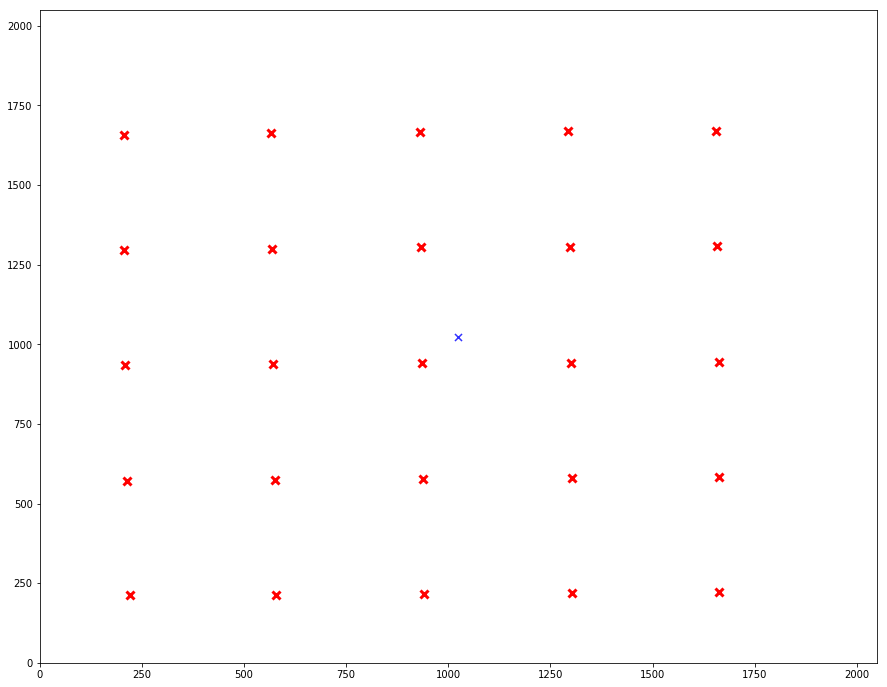

In [6]:
plt.clf()
fig = plt.figure(figsize=(15,12))
image = pyfits.getdata('/home/fatima/Desktop/solar_orbiter_project/codes/targets/calibration_circles.fits')
Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xc = center[1]
yc = center[0]
plt.scatter(xc,yc,marker='x',color='b',s=50,alpha=0.8)
plt.plot(lines[:,0], lines[:,1],'rx',markersize=8,mew=3)
#plt.title('Position of image center',fontsize=22)
plt.xlim(0,2048)
plt.ylim(0,2048)
#plt.plot(columns[:,0], columns[:,1],'bo')
Ny, Nx,xc, yc
#plt.savefig('center_circles.png',dpi=300)

In [7]:
LINES = []; LINES.append(lines[0:5]); LINES.append(lines[5:10]);LINES.append(lines[10:15]); LINES.append(lines[15:20]);LINES.append(lines[20:25]) 

In [8]:
LINES

[array([[  220.21717377,   212.01623007],
        [  579.59500733,   212.6965711 ],
        [  941.36922952,   214.98256122],
        [ 1303.27437075,   218.57452652],
        [ 1663.09986286,   223.67323276]]),
 array([[  214.39306289,   571.44793135],
        [  575.31500623,   573.43152476],
        [  938.36162184,   576.10806905],
        [ 1301.66189552,   579.32104157],
        [ 1663.08232684,   583.2527319 ]]),
 array([[  210.15819593,   933.78505683],
        [  571.80784532,   936.80223584],
        [  935.50157176,   939.8255143 ],
        [ 1299.48562711,   942.77505219],
        [ 1661.42858311,   945.68805427]]),
 array([[  207.49198673,  1296.64741617],
        [  569.05200175,  1300.6959806 ],
        [  932.85565778,  1304.04910981],
        [ 1296.90751445,  1306.55515414],
        [ 1658.60934823,  1308.39407782]]),
 array([[  206.68023749,  1657.58596874],
        [  567.14014042,  1662.97644935],
        [  930.37527937,  1666.786159  ],
        [ 1293.50470295,  

In [9]:
COLUMNS = []; COLUMNS.append(columns[0:5]); COLUMNS.append(columns[5:10]);COLUMNS.append(columns[10:15]);COLUMNS.append(columns[15:20]);  COLUMNS.append(columns[20:25])


In [10]:
len(COLUMNS)

5

In [11]:
def parabola_lines(x,a,b,c):
    y = a*x**2 + b*x + c
    return y
def parabola_columns(y,m,n,p):
    x = m*y**2 + n*y + p
    return x


0.00454414649884
0.00212044340582
0.000216845113457
0.00187517757885
0.00309172445087


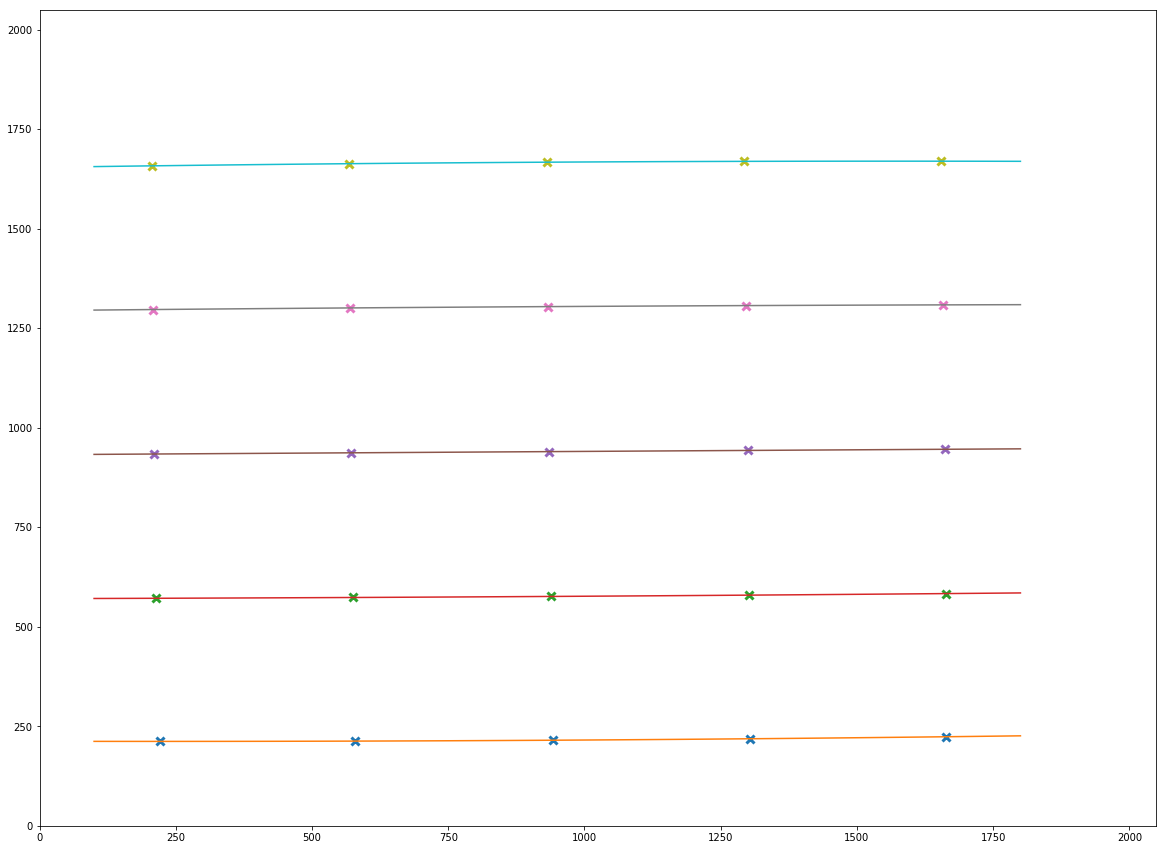

In [12]:
plt.clf()
fig=plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
n=0
A = np.zeros(len(LINES))
B = np.zeros(len(LINES))
C = np.zeros(len(LINES))
for line in LINES:
    x = line[:,0]; y = line[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
    ## GOODNESS OF FIT
    chi_sq_w_lines = np.sum((parabola_lines(x,*popt)-y)**2)
    red_chi_sq_lines = chi_sq_w_lines/(len(x)-len(popt))
    print chi_sq_w_lines
    A[n] = popt[0]; B[n] = popt[1]; C[n] = popt[2]
    xnew = np.linspace(100, 1800, 100)
    ynew = parabola_lines(xnew, *popt)
    ax.plot(x,y,'x',markersize=8,mew=3)
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2048)
    ax.set_ylim(0,2048,2400)
    
    n=n+1

#plt.legend()
plt.savefig('fits_lines.png',dpi=300)
plt.show()

0.00599370468109 0.00299685234055
0.000328586596559 0.00016429329828
0.000194978780779 9.74893903893e-05
0.0131523197788 0.00657615988942
0.0361004197505 0.0180502098753


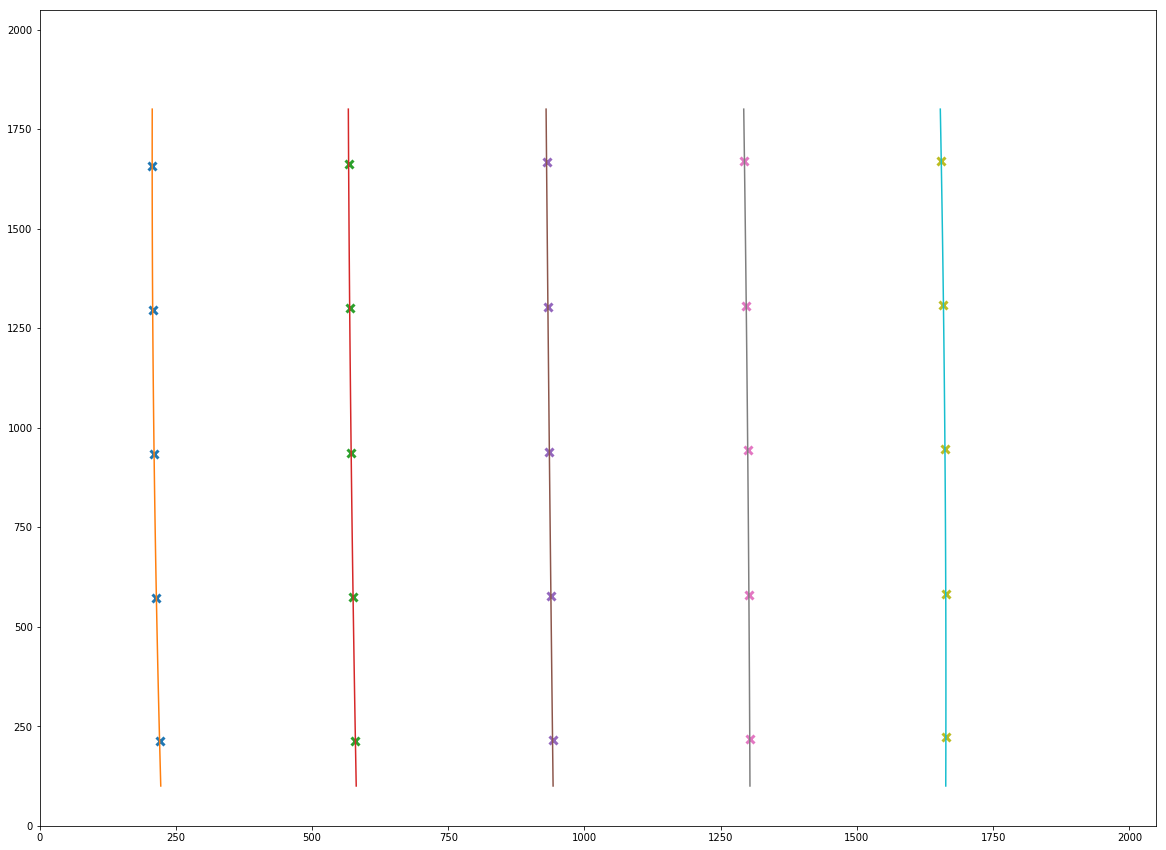

In [13]:
plt.clf()
fig=plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
n=0
M = np.zeros(len(COLUMNS))
N =  np.zeros(len(COLUMNS))
P =  np.zeros(len(COLUMNS))
for col in COLUMNS:
    x = col[:,0]; y = col[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    chi_sq_w_cols = np.sum((parabola_columns(y,*popt)-x)**2)
    red_chi_sq_cols = chi_sq_w_cols/(len(x)-len(popt))
    print chi_sq_w_cols ,red_chi_sq_cols

    
    M[n]=popt[0]; N[n] = popt[1]; P[n] = popt[2]
    ynew = np.linspace(100, 1800, 100)
    xnew = parabola_columns(ynew, *popt)
    ax.plot(x,y,'x',markersize=8,mew=3)
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2048)
    ax.set_ylim(0,2048)
    n=n+1

#plt.legend()
plt.savefig('fits_cols.png',dpi=300)
plt.show()

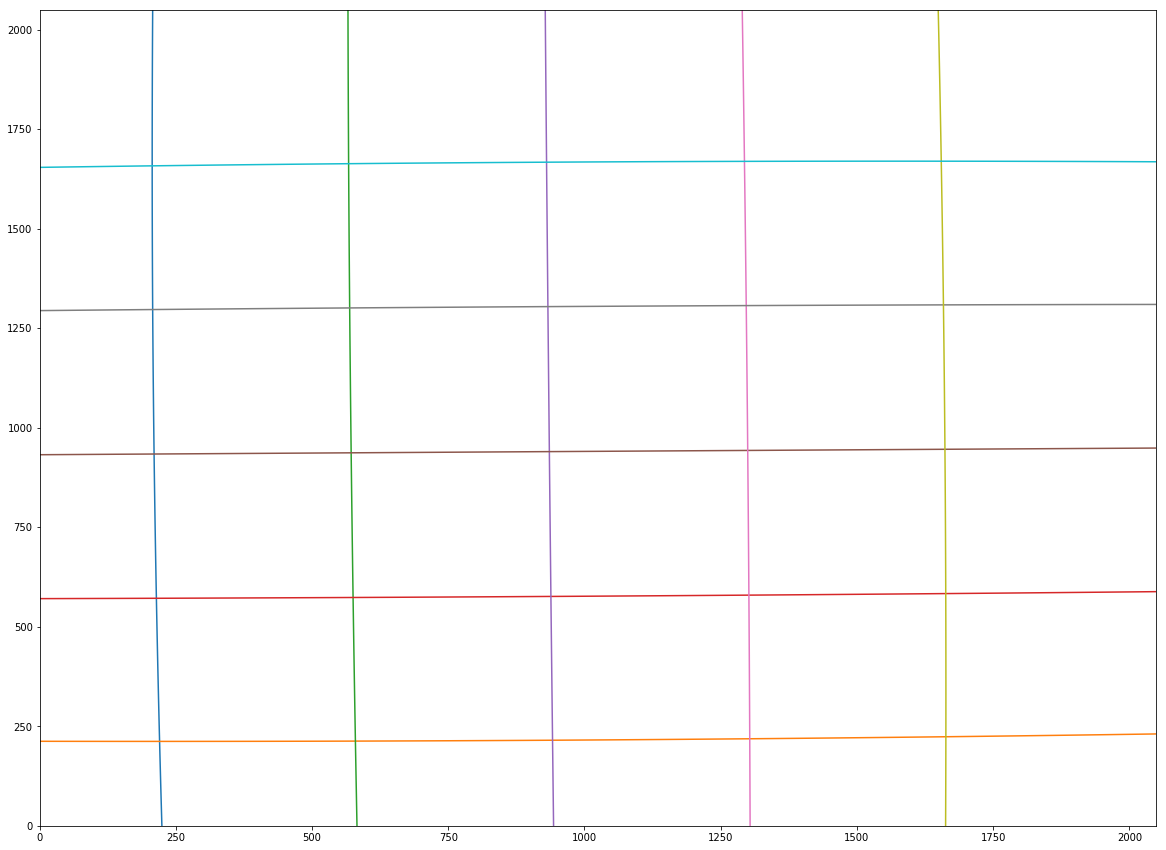

In [14]:
fig=plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)

for col, line in zip(COLUMNS,LINES):
    x = col[:,0]; y = col[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    
    
    ynew = np.linspace(0, 2048, 100)
    xnew = parabola_columns(ynew, *popt)
    #ax.plot(x,y,'x',markersize=8,mew=3)
    ax.plot(xnew, ynew,label=str(n))
    x = line[:,0]; y = line[:,1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
    
    xnew = np.linspace(0, 2048, 100)
    ynew = parabola_lines(xnew, *popt)
    #ax.plot(x,y,'x',markersize=8,mew=3)
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(0,2048)
    ax.set_ylim(0,2048,2400)
    
    n+1
#plt.savefig('grid_circles_dis.png',dpi=300)
plt.show()

# Determining the center of curvature

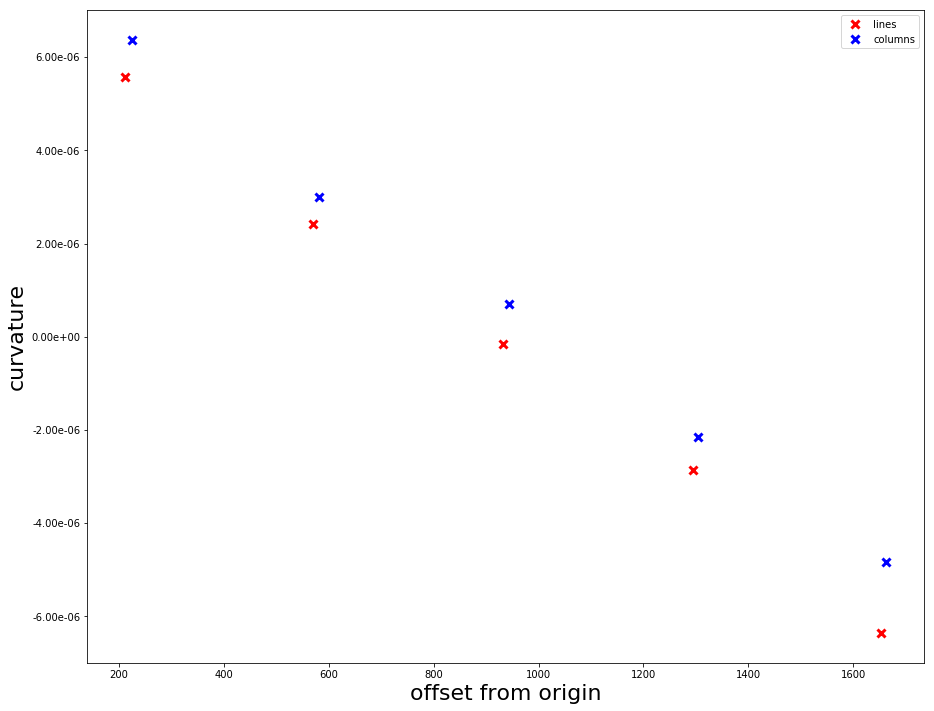

In [15]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.plot(C,A,'rx',label='lines',markersize=8,mew=3)
ax.plot(P,M,'bx',label='columns',markersize=8,mew=3)
ax.set_xlabel('offset from origin',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
#ax.set_xlim(P.min(), P.max())
#ax.set_ylim(A.min(), A.max())
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
#plt.savefig('cvso_origin.png',dpi=300)

In [16]:
## Shifting to center of image to find the distortion center

C_2 = A*xc**2 + B*xc + C - yc #lines
P_2 = M*yc**2 + N*yc + P - xc #columns

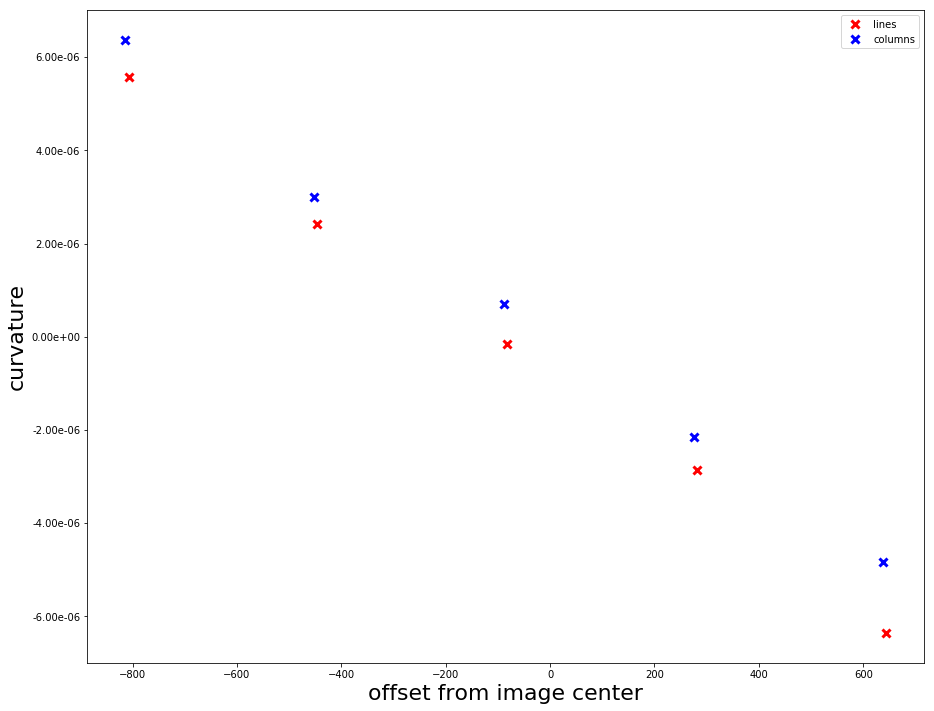

In [17]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.plot(C_2,A,'rx',label='lines',markersize=8,mew=3)
ax.plot(P_2,M,'bx',label='columns',markersize=8,mew=3)
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
#plt.savefig('cvso.png',dpi=300)


[ -8.01979418e-09  -9.41502226e-07]
8.72536722601e-11 2.908455742e-11
[ -7.58350784e-09  -5.29596173e-08]
7.82915377956e-11 2.60971792652e-11


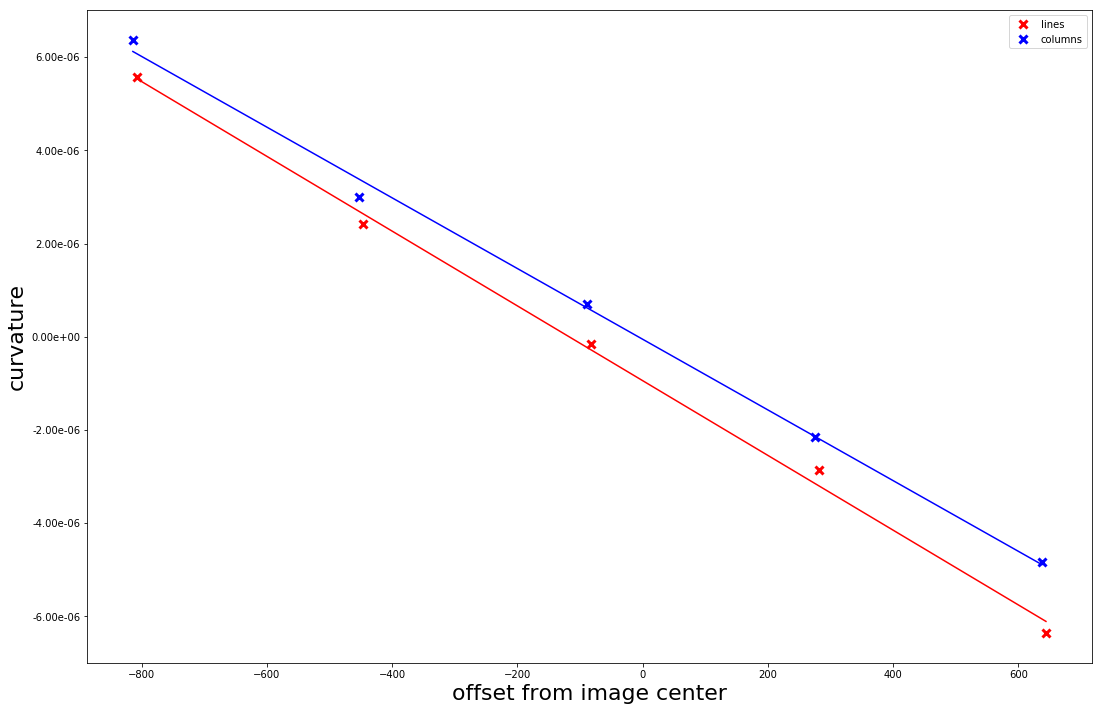

In [18]:
## lines
t = np.polyfit(C_2, A, 1)
tnew = np.linspace(C_2.min(),C_2.max(),100)
model = np.poly1d(t)
Tnew = model(tnew)
## GOODNESS OF FIT
chi_sq_w_lines = np.sum((model(A)-A)**2)
red_chi_sq_lines = chi_sq_w_lines/(len(A)-len(t))
print t
print chi_sq_w_lines,red_chi_sq_lines
## columns
t2 = np.polyfit(P_2, M, 1)
tnew2 = np.linspace(P_2.min(),P_2.max(),100)
model2 = np.poly1d(t2)
Tnew2 = model2(tnew2)
print t2
## goodness of fit
chi_sq_w_cols = np.sum((model2(M)-M)**2)
red_chi_sq_cols = chi_sq_w_cols/(len(M)-len(t2))
print chi_sq_w_cols ,red_chi_sq_cols

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.plot(C_2,A,'rx',label='lines',markersize=8,mew=3)
ax.plot(tnew,Tnew,'r')
ax.plot(P_2,M,'bx',label='columns',markersize=8,mew=3)
ax.plot(tnew2, Tnew2, 'b')
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
#plt.savefig('cvso_fits.png',dpi=300)


In [19]:
## Finding distortion center:

del_lines = -t[1]/t[0]
del_columns = -t2[1]/t2[0]
y_d = del_lines+yc
x_d = del_columns + xc
print 'the distortion center is:', (x_d,y_d)
del_lines, del_columns

the distortion center is: (1016.5164749077924, 906.10269466688499)


(-117.39730533311499, -6.9835250922076071)

1023.5


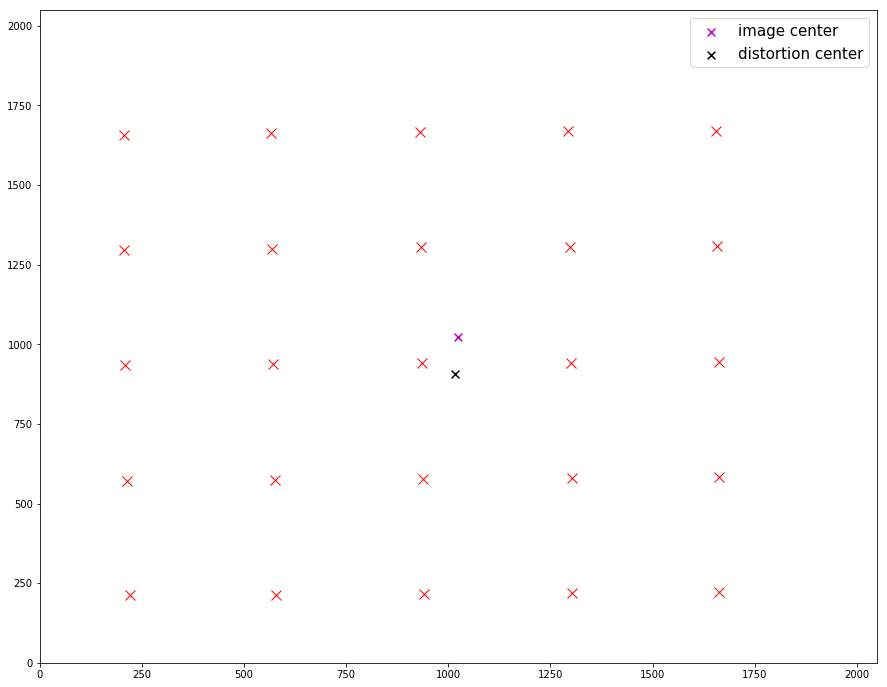

In [20]:
plt.clf()
fig = plt.figure(figsize=(15,12))
plt.scatter(xc,yc,marker='x', color='m', s=60,label='image center')
plt.scatter(x_d,y_d,marker='x',color='k', s=60,label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.plot(columns[:,0], columns[:,1],'xr', markersize=10)
plt.legend(loc='best', prop={'size': 15})
print xc

# Refining the position of the distortion center

In [21]:

Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xd = center[1]
yd = center[0]
C_2 = A*xd**2 + B*xd + C - yd #lines
P_2 = M*yd**2 + N*yd + P - xd #columns
trials = 10
i=0
temp_x = temp_y = np.zeros((trials))


In [22]:
for n in range(trials):
    
    t = np.polyfit(C_2, A, 1)
    t2 = np.polyfit(P_2, M, 1)
    
    del_lines = -t[1]/t[0]
    del_columns = -t2[1]/t2[0]
    yd = del_lines+yd
    xd = del_columns + xd
    print 'the distortion center is:', (xd,yd)
    print del_lines, del_columns
   
    C_2 = A*xd**2 + B*xd + C - yd#lines
    P_2 = M*yd**2 + N*yd + P - xd #columns
    temp_x[i] = xd
    temp_y[i] = yd
    i=i+1


the distortion center is: (1016.5164749077924, 906.10269466688499)
-117.397305333 -6.98352509221
the distortion center is: (1017.383808551847, 906.04624252300107)
-0.0564521438839 0.867333644055
the distortion center is: (1017.3842256328891, 906.05325372047457)
0.0070111974735 0.000417081042107
the distortion center is: (1017.3841738325964, 906.05325709199997)
3.37152544997e-06 -5.18002927216e-05
the distortion center is: (1017.3841738076867, 906.05325667326599)
-4.18733989729e-07 -2.49096566055e-08
the distortion center is: (1017.3841738107803, 906.05325667306454)
-2.01439369946e-10 3.09366384725e-09
the distortion center is: (1017.3841738107818, 906.05325667308966)
2.50720209075e-11 1.50630064545e-12
the distortion center is: (1017.3841738107816, 906.05325667308955)
-1.30279503415e-13 -1.93219838728e-13
the distortion center is: (1017.3841738107817, 906.05325667308955)
1.28948558017e-14 1.4042477596e-13
the distortion center is: (1017.3841738107818, 906.05325667308955)
1.28948558017e

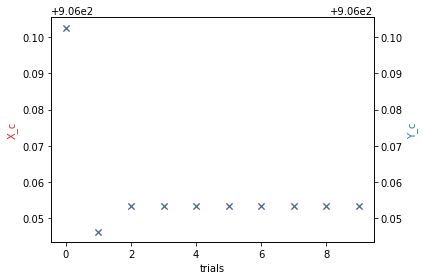

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('trials')
ax1.set_ylabel('X_c', color=color)
ax1.plot(np.arange(trials), temp_x, 'rx',color=color)
#ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Y_c', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(trials), temp_y,'bx' ,color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.clf()

In [24]:
## The final center of distortion:
x_d = xd
y_d = yd

In [25]:
## parabola coefficient in the new reference of distortion center
C_3 = A*x_d**2 + B*x_d + C - y_d
P_3 = M*y_d**2 + N*y_d + P - x_d
B_3 = 2*A*x_d + B
N_3 = 2*M*y_d + N

[ -8.01972624e-09   1.03413213e-22]
8.54586238832e-11 2.84862079611e-11
[ -7.58537939e-09  -1.46564578e-21]
7.79503285971e-11 2.59834428657e-11


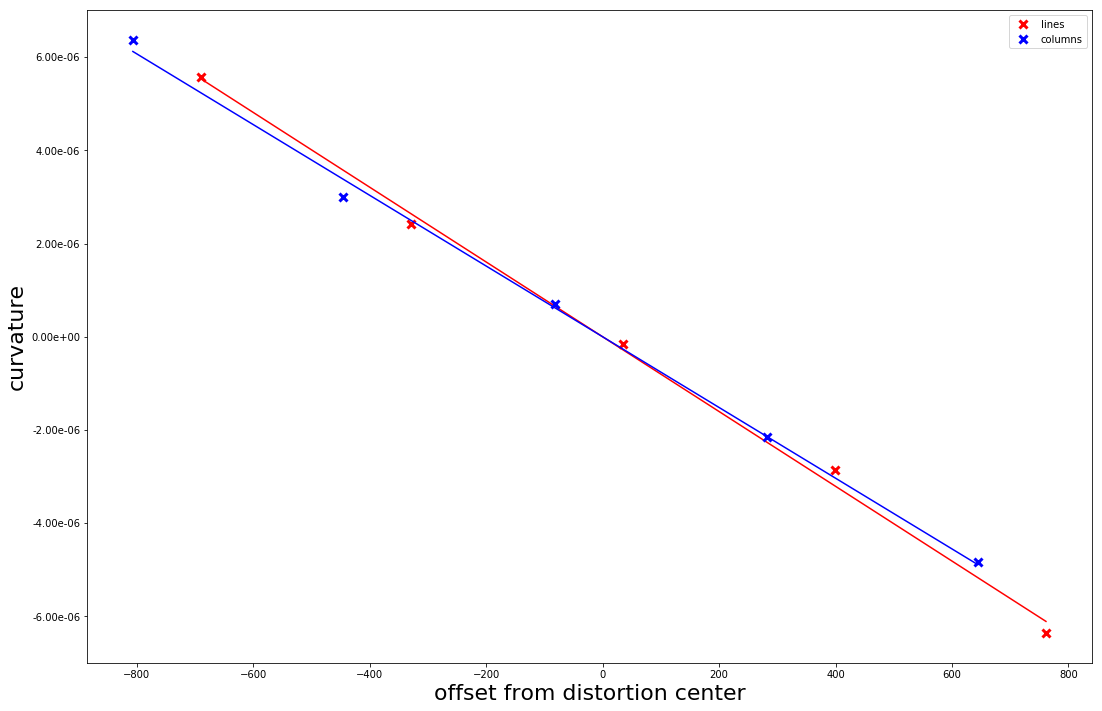

In [26]:
t = np.polyfit(C_3, A, 1)
tnew = np.linspace(C_3.min(),C_3.max(),100)
model = np.poly1d(t)
Tnew = model(tnew)
## GOODNESS OF FIT
chi_sq_w_lines = np.sum((model(A)-A)**2)
red_chi_sq_lines = chi_sq_w_lines/(len(A)-len(t))
print t
print chi_sq_w_lines,red_chi_sq_lines
## columns
t2 = np.polyfit(P_3, M, 1)
tnew2 = np.linspace(P_3.min(),P_3.max(),100)
model2 = np.poly1d(t2)
Tnew2 = model2(tnew2)
print t2
## goodness of fit
chi_sq_w_cols = np.sum((model2(M)-M)**2)
red_chi_sq_cols = chi_sq_w_cols/(len(M)-len(t2))
print chi_sq_w_cols ,red_chi_sq_cols

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.plot(C_3,A,'rx',label='lines',markersize=8,mew=3)
ax.plot(tnew,Tnew,'r')
ax.plot(P_3,M,'bx',label='columns',markersize=8,mew=3)
ax.plot(tnew2, Tnew2, 'b')
ax.set_xlabel('offset from distortion center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
plt.savefig('cvso_final.png',dpi=300)

1017.38417381 906.053256673


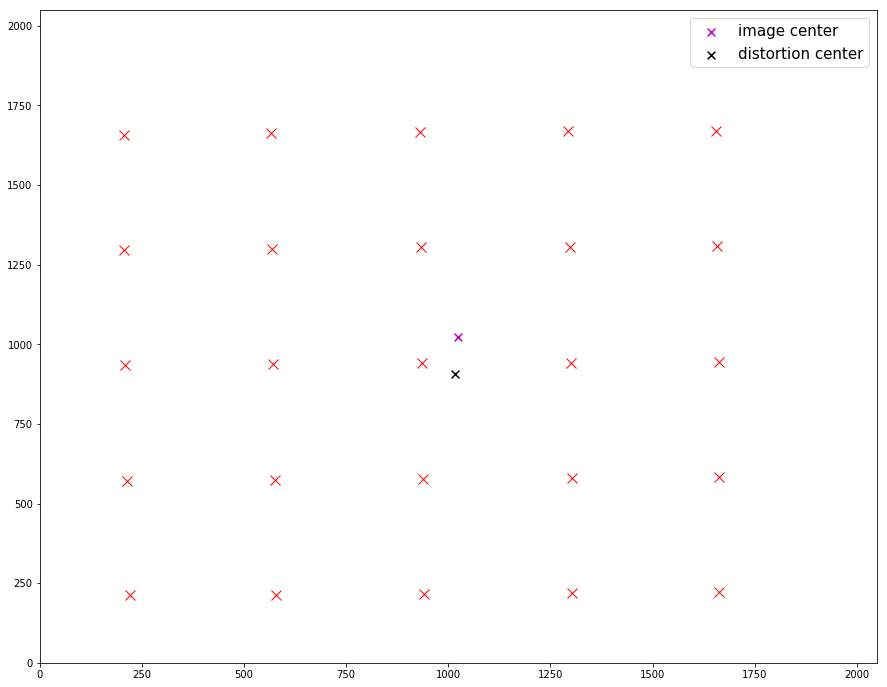

In [27]:
plt.clf()
fig = plt.figure(figsize=(15,12))
plt.scatter(1023,1023,marker='x', color='m', s=60,label='image center')
plt.scatter(x_d,y_d,marker='x',color='k', s=60,label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.plot(columns[:,0], columns[:,1],'xr', markersize=10)
plt.legend(loc='best', prop={'size': 15})
print x_d, y_d
#plt.savefig('center.png',dpi=300)

# Correcting for aspect ratio

In [28]:
## slope of curvature versus offset in the lines
s_x = t[0]

## slope of curvature versus offset in columns
s_y = t2[0]

## aspect ratio
AR = np.sqrt(np.abs(s_x/s_y))
print AR



1.02823200535


In [29]:
## correcting the coefficients:
M_4 = M/AR
N_4 = N_3/AR
P_4 = P_3/AR

A_4 = A*AR**2
B_4 = B_3*AR
C_4 = C_3

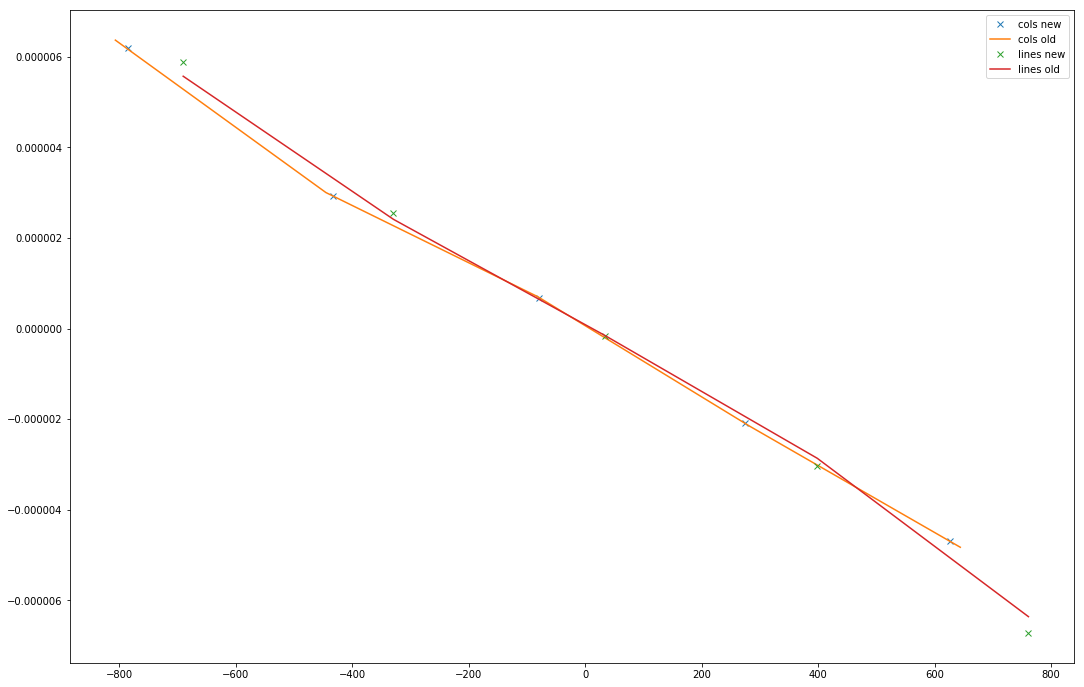

In [30]:
plt.figure(figsize=(18,12))
plt.plot(P_4,M_4,'x',label='cols new')
plt.plot(P_3,M,label='cols old')
plt.plot(C_4,A_4,'x',label='lines new')
plt.plot(C_3,A,label='lines old')
plt.legend()

plt.show()


# computing the distortion coefficient

7.1464788172e-09
7.91589624441e-09


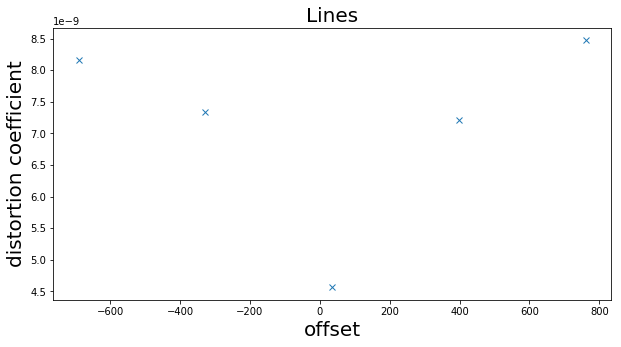

In [31]:
k_lines = (-A)/(C_3*(3*A*C_3 + 3*B_3**2 + 1))
plt.figure(figsize=(10,5))
plt.plot(C_3, k_lines,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines.mean()
print np.average(k_lines,weights=np.abs(C_3))
#plt.savefig('k_lines.png')

7.55878725243e-09
8.3739023899e-09


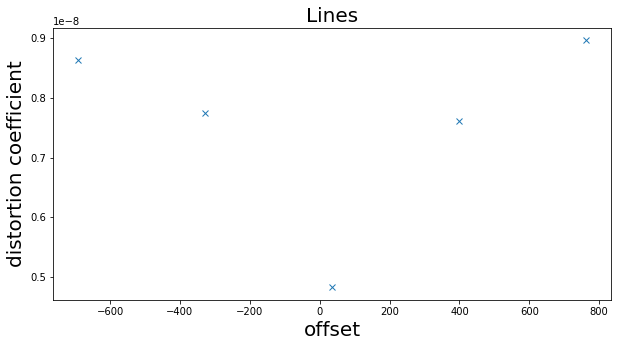

In [32]:
k_lines_4 = (-A_4)/(C_4*(3*A_4*C_4 + 3*B_4**2 + 1))
plt.figure(figsize=(10,5))
plt.plot(C_4, k_lines_4,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines_4.mean()
print np.average(k_lines_4,weights=np.abs(C_4))

In [117]:
'''
## removing the outlier:
np.where(k_lines==k_lines.min())
k_lines_2 = np.delete(k_lines,[2])
print k_lines_2, k_lines_2.shape
'''

'\n## removing the outlier:\nnp.where(k_lines==k_lines.min())\nk_lines_2 = np.delete(k_lines,[2])\nprint k_lines_2, k_lines_2.shape\n'

7.71945352892e-09
7.61214233369e-09


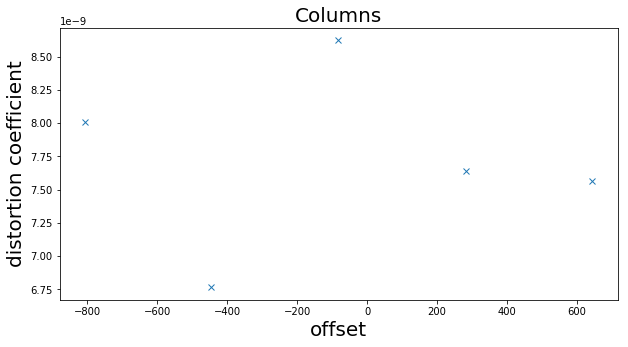

In [33]:
plt.figure(figsize=(10,5))
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Columns',fontsize=20)
k_cols = (-M)/(P_3*(3*M*P_3+ 3*N_3**2 + 1))
plt.plot(P_3,k_cols,'x')
print k_cols.mean()
print np.average(k_cols,weights=np.abs(P_3))
#plt.savefig('k_cols.png')

7.71821699488e-09
7.61024287305e-09


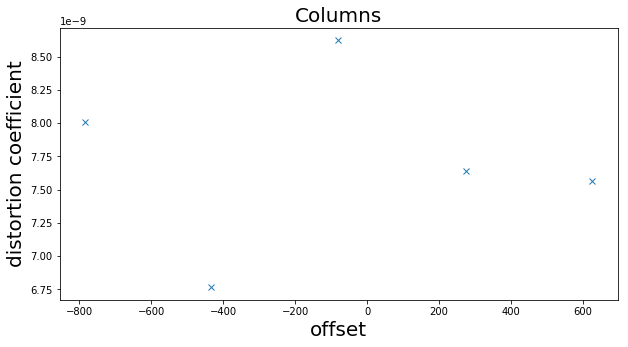

In [35]:
plt.figure(figsize=(10,5))
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Columns',fontsize=20)
k_cols_4 = (-M_4)/(P_4*(3*M*P_4+ 3*N_4**2 + 1))
plt.plot(P_4,k_cols,'x')
print k_cols_4.mean()
print np.average(k_cols_4,weights=np.abs(P_4))

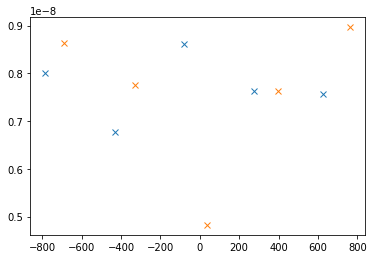

In [35]:
plt.plot(P_4,k_cols,'x')
plt.plot(C_4, k_lines,'x')


In [39]:
K = np.array([k_lines.mean() ,k_cols.mean()])
print K.mean()
K = np.array([k_lines_4.mean() ,k_cols_4.mean()])
print K.mean()
K = np.array([np.average(k_lines, weights=np.abs(C_3)), np.average(k_cols, weights=np.abs(P_3))])
print K.mean()
K = np.array([np.average(k_lines_4, weights=np.abs(C_4)), np.average(k_cols_4, weights=np.abs(P_4))])
print K.mean()


7.43296617306e-09
7.63850212365e-09
7.76401928905e-09
7.99207263147e-09


In [40]:
K = np.array([np.average(k_lines_4, weights=np.abs(C_4)), np.average(k_cols_4, weights=np.abs(P_4))])

print "the distortion coefficient is k =", K.mean()

the distortion coefficient is k = 7.99207263147e-09


In [42]:
x_d = xd
y_d = yd

print x_d,y_d
k = K.mean()
# correcting for distortion
## loading all data points
f = np.loadtxt('/home/fatima/Desktop/solar_orbiter_project/codes/dont_touch/centers_python_lines_circles')
X_d = f[:,0] 
Y_d = f[:,1] 

1017.38417381 906.053256673


In [43]:
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))


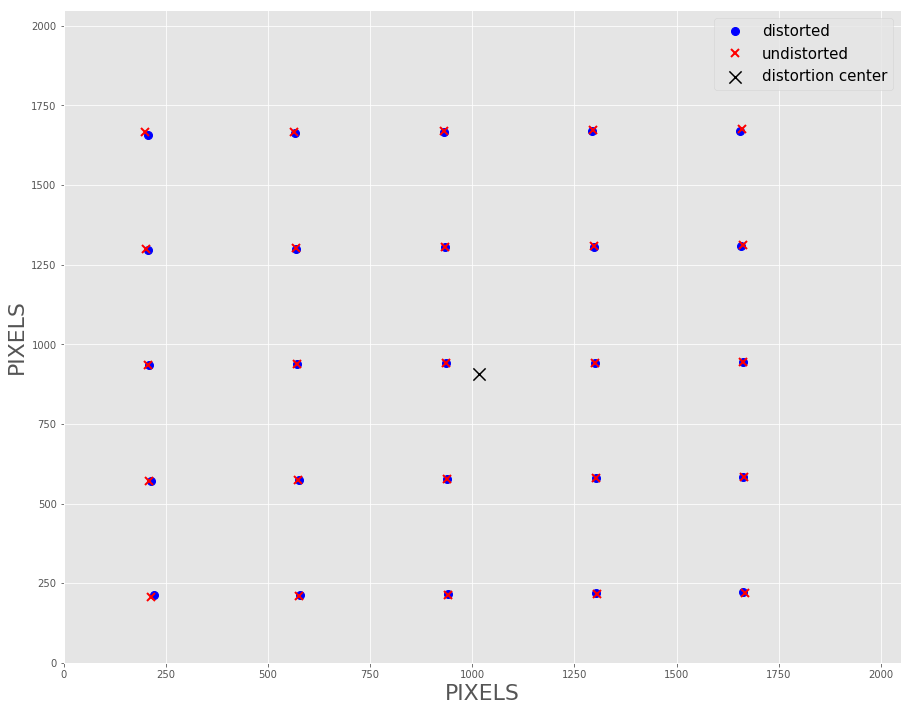

In [44]:
fig = plt.figure(figsize=(15,12))
plt.style.use('ggplot')
ax = fig.add_subplot(111)

#plt.scatter(xc,yc,marker='x',color='m',label='image center')
plt.scatter(x_d,y_d,marker='x',color='k',s=150,alpha=1,label='distortion center')
#plt.plot(lines[:,0], lines[:,1],'rx')
ax.plot(X_d, Y_d,'bo', markersize=8 ,label='distorted')
ax.plot(X_u,Y_u, 'rx', markersize=8,mew=2, label='undistorted')
plt.xlim(0,2048)
plt.ylim(0,2048)
plt.xlabel('PIXELS',fontsize=22)
plt.ylabel('PIXELS',fontsize=22)
#rec = plt.Rectangle((0,0), width=Nx,height=Ny, fill='False')
#ax.add_patch(rec)
rms = 4.5 
percent = -0.4
k=8e-09
textstr = '\n'.join((
    r'RMS error=%.2f' % (rms, ) +' pixels',
    r'percentage of Distortion=%.2f' % (percent, )+'%',
    r'Distortion coefficient k=%.2E' % (k, )))
text = r'$r_u = r_d \times (1+k\times r_d^2)$'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

#ax.text(0.4, 0.95, text, transform=ax.transAxes, fontsize=20,verticalalignment='top', bbox=props)

plt.legend(loc='upper right',prop={'size': 15} )
#plt.savefig('distortion.png',dpi=300)

# Distortion measure



In [45]:
plate_scale = 0.5
d_m_pixels = np.sqrt((1./len(X_u))*np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))
d_m_arc = d_m_pixels*plate_scale
d_m_km = d_m_arc*725
print "the distortion is around:",'\n', d_m_pixels, 'pixels', '\n', d_m_arc, 'arcseconds', '\n',d_m_km, 'km'

the distortion is around: 
4.567086651 pixels 
2.2835433255 arcseconds 
1655.56891099 km


In [46]:
np.sqrt((X_u-X_d)**2+(Y_u-Y_d)**2)

array([  9.43700133e+00,   4.40660110e+00,   2.68572419e+00,
         3.29873552e+00,   6.62672345e+00,   5.26129625e+00,
         1.35323841e+00,   3.12118776e-01,   6.49227223e-01,
         3.00658779e+00,   4.21127118e+00,   7.12066828e-01,
         5.55361675e-03,   1.84001550e-01,   2.14718451e+00,
         5.80992756e+00,   1.70292517e+00,   5.38315086e-01,
         9.31081666e-01,   3.46693553e+00,   1.07966438e+01,
         5.45959140e+00,   3.58775438e+00,   4.26601223e+00,
         7.85744820e+00])

In [50]:
# disortionpercent:
D=((np.sqrt((X_d-x_d)**2+(Y_d-y_d)**2) - np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))/np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))*100
print D.mean()
print np.abs(D).max()

-0.423568369115
0.967218587648


In [51]:
np.sqrt(((X_u-X_d)**2+(Y_u-Y_d)**2)).max()


10.796643836493956

# Stright lines fit according to the computed K

[  9.03364482e-03  -6.93096182e+02]
[   111.39355694  77202.82785447]
[  8.54203109e-03  -3.29596059e+02]
[   116.72514226  38478.40990787]
[  8.17761802e-03   3.44398879e+01]
[  122.56760223 -4224.9268013 ]
[  7.63183716e-03   3.99145598e+02]
[   132.01577409 -52703.85804444]
[  7.04995172e-03   7.64888191e+02]
[    141.04621402 -107871.05239603]


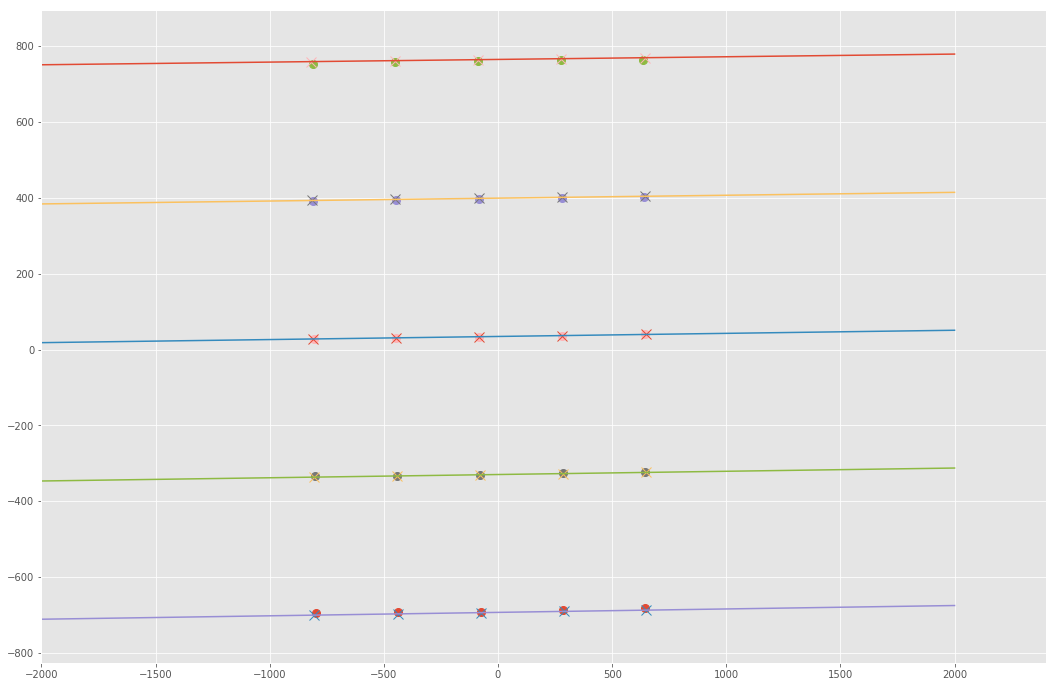

In [54]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0

for line in LINES:
    X_d = line[:,0] -x_d  
    Y_d = line[:,1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B_3[n]*(3*k*C_3[n]**2 +1), C_3[n]*(k*C_3[n]**2+1)])
    t_fit = np.polyfit(Y_u,X_u, 1)

    print params
    print t_fit 
    xnew = np.linspace(-2000, 2000, 100)
    ynew = params[0]*xnew + params[1]
    ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    ax.plot(X_u,Y_u,'x',markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    ax.set_xlim(-2000,2400)
    ax.set_ylim(80-y_d,1800-y_d)
    n=n+1

#plt.legend()
plt.savefig('polyfits_lines.png',dpi=300)
plt.show()

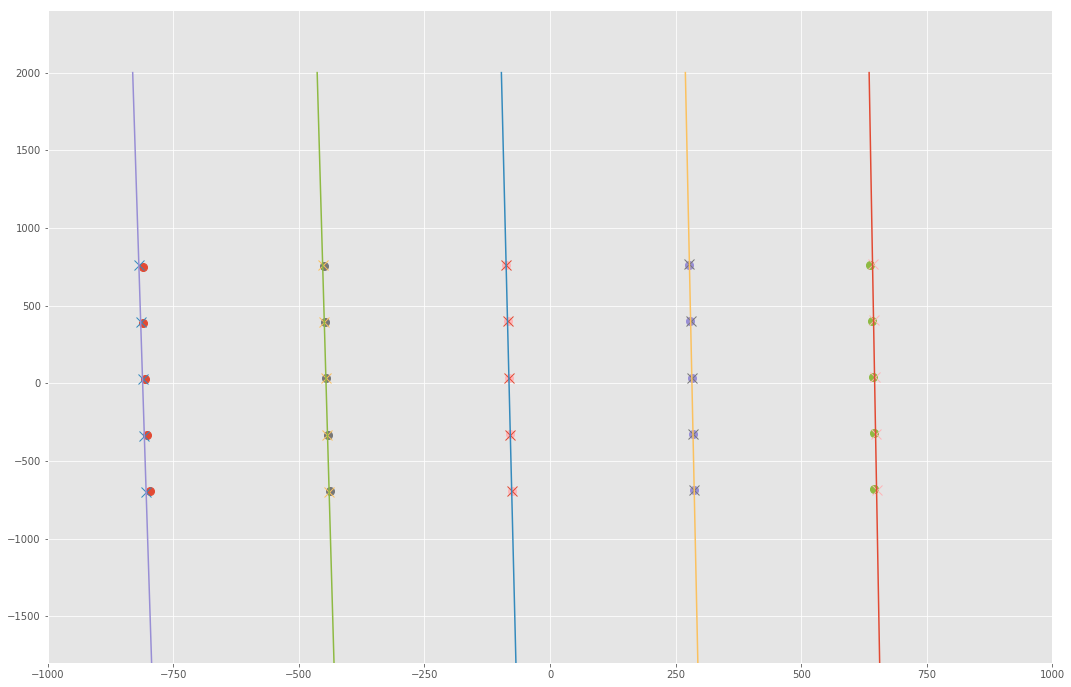

In [55]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0

for col in COLUMNS:
    X_d = col[:,0] - x_d
    Y_d = col[:,1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N_3[n]*(3*k*P_3[n]**2 +1), P_3[n]*(k*P_3[n]**2+1)])
    ynew = np.linspace(-2000,2000, 100)
    xnew = params[0]*ynew + params[1]    
    ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    ax.plot(X_u,Y_u,'x', markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    ax.set_xlim(-1000,1000)
    ax.set_ylim(-1800,2400)
    n=n+1

#plt.legend()
plt.savefig('polyfits_cols.png',dpi=300)
plt.show()


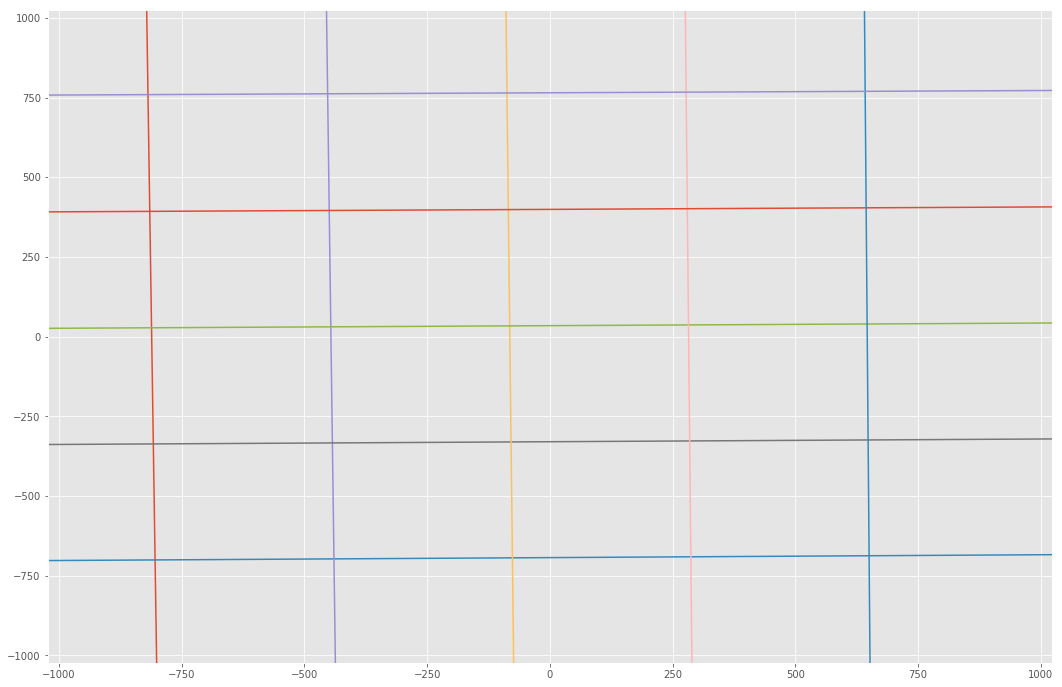

In [77]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0

for col,line in zip(COLUMNS,LINES):
    X_d = col[:,0] - x_d
    Y_d = col[:,1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N_3[n]*(3*k*P_3[n]**2 +1), P_3[n]*(k*P_3[n]**2+1)])
    ynew = np.linspace(-2000,2000, 100)
    xnew = params[0]*ynew + params[1]    
    #ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    #ax.plot(X_u,Y_u,'x', markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
   
    X_d = line[:,0] -x_d  
    Y_d = line[:,1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B_3[n]*(3*k*C_3[n]**2 +1), C_3[n]*(k*C_3[n]**2+1)])
    t_fit = np.polyfit(Y_u,X_u, 1)

   
    xnew = np.linspace(-2000, 2000, 100)
    ynew = params[0]*xnew + params[1]
    #ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    #ax.plot(X_u,Y_u,'x',markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    ax.set_xlim(-1023,1023)
    
    ax.set_ylim(-1023,1023)
    n=n+1

#plt.legend()
plt.savefig('grid_circles_und.png',dpi=300)
plt.show()

# center of distortion is image center

In [185]:
Ny, Nx = image.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xc = center[1]
yc = center[0]


In [186]:

C_2 = A*xc**2 + B*xc + C - yc #lines
P_2 = M*yc**2 + N*yc + P - xc #columns
B_2 = 2*A*xc + B
N_2 = 2*M*yc + N



[  6.98477869e-09   5.41140532e-09  -1.89366911e-09   1.02041283e-08
   9.99494225e-09]
6.1403170789e-09
7.6054168272e-09


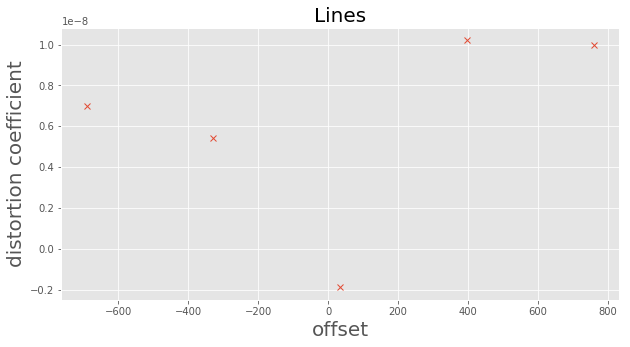

In [187]:
k_lines = (-A)/(C_2*(3*A*C_2 + 3*B_2**2 + 1))
plt.figure(figsize=(10,5))
plt.plot(C_3, k_lines,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines
print k_lines.mean()
print np.average(k_lines,weights=np.abs(C_2))
#plt.savefig('k_lines.png')

[  7.93941562e-09   6.65920144e-09   7.94167703e-09   7.83130435e-09
   7.64131163e-09]
7.60258201274e-09
7.58722848662e-09


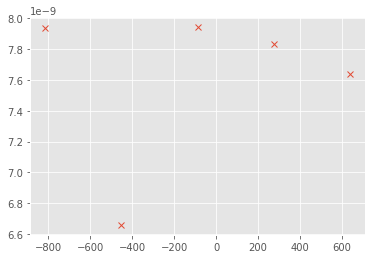

In [189]:
k_cols = (-M)/(P_2*(3*M*P_2+ 3*N_2**2 + 1))
plt.plot(P_2,k_cols,'x')
print k_cols
print k_cols.mean()
print np.average(k_cols,weights=np.abs(P_2))

In [190]:
K = np.array([np.average(k_lines, weights=np.abs(C_2)), np.average(k_cols, weights=np.abs(P_2))])

print "the distortion coefficient is k =", K.mean()

the distortion coefficient is k = 7.59632265691e-09


In [192]:
f = np.loadtxt(p+'/dont_touch/centers_python_lines_circles')
X_d = f[:,0] 
Y_d = f[:,1] 
x_d = xc
y_d =yc

In [193]:
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))


In [194]:
plate_scale = 0.5
d_m_pixels = np.sqrt((1./len(X_u))*np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))
d_m_arc = d_m_pixels*plate_scale
d_m_km = d_m_arc*725
print "the distortion is around:",'\n', d_m_pixels, 'pixels', '\n', d_m_arc, 'arcseconds', '\n',d_m_km, 'km'

the distortion is around: 
4.72359784649 pixels 
2.36179892324 arcseconds 
1712.30421935 km


In [197]:
R = np.sqrt(((X_u-X_d)**2+(Y_u-Y_d)**2))
print np.where(R==R.max())
print R.max()
print X_u[0], X_d[0]
print Y_u[0], Y_d[0] 
D[0]

(array([0]),)
11.8976311733
211.847112757 220.217173772
203.56071671 212.016230068


-1.0312365232259961

## equivalence

In [253]:
f = np.loadtxt(p+'/dont_touch/centers_python_lines_circles')
X_d = f[:,0] 
Y_d = f[:,1]      
x_d = 1017.3841738107818
y_d = 906.05325667308955
k = 7.99207263147e-09
P1 = -k*x_d
P2 = -k*y_d
def model_x(params,X_d,Y_d,X_u,Y_u):
     xc = params[0]
     yc = params[1]
     r_d = np.sqrt((X_d-xc)**2 + (Y_d-yc)**2)
     x_u = X_d+(X_d-xc)*k*(r_d)**2 +P1*(r_d**2+2*(X_d-xc)**2)+2*P2*(X_d-xc)*(Y_d-yc)
     y_u = Y_d + (Y_d - yc)*k*(r_d)**2 +2*P1*(X_d-xc)*(Y_d-yc) + P2*(r_d**2+2*(Y_d-yc)**2)
     return np.sum((x_u-X_u)**2)
     

In [267]:
import scipy
p0 = [1023,1023]
def Con(params): 
     xc = params[0]
     yc = params[1]
     r_d = np.sqrt((X_d-xc)**2 + (Y_d-yc)**2) 
     x_u = X_d+(X_d-xc)*k*(r_d)**2 +P1*(r_d**2+2*(X_d-xc)**2)+2*P2*(X_d-xc)*(Y_d-yc)
     y_u = Y_d + (Y_d - yc)*k*(r_d)**2 +2*P1*(X_d-xc)*(Y_d-yc) + P2*(r_d**2+2*(Y_d-yc)**2)
        
     d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-X_d)**2+(y_u-Y_d)**2))
     return 5-d_m_pixels

cons = ({'type':'ineq','fun':Con})

mini_x = scipy.optimize.minimize(model_x, p0, args=(X_d,Y_d,X_u,Y_u),constraints=cons,method='SLSQP')


In [268]:
mini_x.x

array([ 820.8973519,  838.1758577])

In [269]:
xc = mini_x.x[0]
yc = mini_x.x[1]

In [270]:
     r_d = np.sqrt((X_d-xc)**2 + (Y_d-yc)**2)


In [271]:
     x_u = X_d+(X_d-xc)*k*(r_d)**2 +P1*(r_d**2+2*(X_d-xc)**2)+2*P2*(X_d-xc)*(Y_d-yc)


In [272]:
     y_u = Y_d + (Y_d - yc)*k*(r_d)**2 +2*P1*(X_d-xc)*(Y_d-yc) + P2*(r_d**2+2*(Y_d-yc)**2)


In [273]:
d_m_pixels = np.sqrt((1./len(x_u))*np.sum((x_u-X_d)**2+(y_u-Y_d)**2))


In [274]:
d_m_pixels

14.025548227691884